In [1]:
# Import libraries and modules
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
print(np.__version__)
print(tf.__version__)
np.set_printoptions(threshold=np.inf)

1.18.5
2.3.0


# Local Development

## Arguments

In [2]:
arguments = {}
# File arguments.
arguments["train_file_pattern"] = "gs://machine-learning-1234-bucket/gan/data/mnist/train*.tfrecord"
arguments["eval_file_pattern"] = "gs://machine-learning-1234-bucket/gan/data/mnist/test*.tfrecord"
arguments["output_dir"] = "gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model"

# Training parameters.
arguments["tf_version"] = 2.2
arguments["use_graph_mode"] = True
arguments["distribution_strategy"] = ""
arguments["write_summaries"] = False
arguments["num_epochs"] = 30
arguments["train_dataset_length"] = 60000
arguments["train_batch_size"] = 32
arguments["log_step_count_steps"] = 100
arguments["save_summary_steps"] = 100
arguments["save_checkpoints_steps"] = 10000
arguments["keep_checkpoint_max"] = 10
arguments["input_fn_autotune"] = False

# Eval parameters.
arguments["eval_batch_size"] = 32
arguments["eval_steps"] = 100

# Image parameters.
arguments["height"] = 28
arguments["width"] = 28
arguments["depth"] = 1

# Shared network parameters.
arguments["num_steps_until_growth"] = 150

# Full lists for full 1024x1024 network growth.
full_conv_num_filters = [[512, 512], [512, 512], [512, 512], [512, 512], [256, 256], [128, 128], [64, 64], [32, 32], [16, 16]]
full_conv_kernel_sizes = [[4, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3]]
full_conv_strides = [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]]
image_size = min(100, len(full_conv_num_filters))
arguments["conv_num_filters"] = full_conv_num_filters[0:image_size]
arguments["conv_kernel_sizes"] = full_conv_kernel_sizes[0:image_size]
arguments["conv_strides"] = full_conv_strides[0:image_size]

# Generator parameters.
arguments["latent_size"] = 512
arguments["generator_projection_dims"] = [4, 4, 256]
arguments["generator_leaky_relu_alpha"] = 0.2
arguments["generator_final_activation"] = "tanh"
arguments["generator_l1_regularization_scale"] = 0.
arguments["generator_l2_regularization_scale"] = 0.
arguments["generator_optimizer"] = "Adam"
arguments["generator_learning_rate"] = 0.001
arguments["generator_adam_beta1"] = 0.0
arguments["generator_adam_beta2"] = 0.99
arguments["generator_adam_epsilon"] = 1e-8
arguments["generator_clip_gradients"] = None
arguments["generator_train_steps"] = 1

# Discriminator hyperparameters.
arguments["discriminator_leaky_relu_alpha"] = 0.2
arguments["discriminator_l1_regularization_scale"] = 0.
arguments["discriminator_l2_regularization_scale"] = 0.
arguments["discriminator_optimizer"] = "Adam"
arguments["discriminator_learning_rate"] = 0.001
arguments["discriminator_adam_beta1"] = 0.0
arguments["discriminator_adam_beta2"] = 0.99
arguments["discriminator_adam_epsilon"] = 1e-8
arguments["discriminator_clip_gradients"] = None
arguments["discriminator_train_steps"] = 1
arguments["label_smoothing"] = 0.9


In [3]:
def calc_generator_discriminator_conv_layer_properties(
        conv_num_filters, conv_kernel_sizes, conv_strides, depth):
    """Calculates generator and discriminator conv layer properties.

    Args:
        num_filters: list, nested list of ints of the number of filters
            for each conv layer.
        kernel_sizes: list, nested list of ints of the kernel sizes for
            each conv layer.
        strides: list, nested list of ints of the strides for each conv
            layer.
        depth: int, depth dimension of images.

    Returns:
        Nested lists of conv layer properties for both generator and
            discriminator.
    """
    def make_generator(num_filters, kernel_sizes, strides, depth):
        """Calculates generator conv layer properties.

        Args:
            num_filters: list, nested list of ints of the number of filters
                for each conv layer.
            kernel_sizes: list, nested list of ints of the kernel sizes for
                each conv layer.
            strides: list, nested list of ints of the strides for each conv
                layer.
            depth: int, depth dimension of images.

        Returns:
            Nested list of conv layer properties for generator.
        """
        # Get the number of growths.
        num_growths = len(num_filters) - 1

        # Make base block.
        in_out = num_filters[0]
        base = [
            [kernel_sizes[0][i]] * 2 + in_out + [strides[0][i]] * 2
            for i in range(len(num_filters[0]))
        ]
        blocks = [base]

        # Add growth blocks.
        for i in range(1, num_growths + 1):
            in_out = [[blocks[i - 1][-1][-3], num_filters[i][0]]]
            block = [[kernel_sizes[i][0]] * 2 + in_out[0] + [strides[i][0]] * 2]
            for j in range(1, len(num_filters[i])):
                in_out.append([block[-1][-3], num_filters[i][j]])
                block.append(
                    [kernel_sizes[i][j]] * 2 + in_out[j] + [strides[i][j]] * 2
                )
            blocks.append(block)

        # Add toRGB conv.
        blocks[-1].append([1, 1, blocks[-1][-1][-3], depth] + [1] * 2)

        return blocks

    def make_discriminator(generator):
        """Calculates discriminator conv layer properties.

        Args:
            generator: list, nested list of conv layer properties for
                generator.

        Returns:
            Nested list of conv layer properties for discriminator.
        """
        # Reverse generator.
        discriminator = generator[::-1]

        # Reverse input and output shapes.
        discriminator = [
            [
                conv[0:2] + conv[2:4][::-1] + conv[-2:]
                for conv in block[::-1]
            ]
            for block in discriminator
        ]

        return discriminator

    # Calculate conv layer properties for generator using args.
    generator = make_generator(
        conv_num_filters, conv_kernel_sizes, conv_strides, depth
    )

    # Calculate conv layer properties for discriminator using generator
    # properties.
    discriminator = make_discriminator(generator)

    return generator, discriminator


def split_up_generator_conv_layer_properties(
        generator, num_filters, strides, depth):
    """Splits up generator conv layer properties into lists.

    Args:
        generator: list, nested list of conv layer properties for
            generator.
        num_filters: list, nested list of ints of the number of filters
            for each conv layer.
        strides: list, nested list of ints of the strides for each conv
            layer.
        depth: int, depth dimension of images.

    Returns:
        Nested lists of conv layer properties for generator.
    """
    generator_base_conv_blocks = [generator[0][0:len(num_filters[0])]]

    generator_growth_conv_blocks = []
    if len(num_filters) > 1:
        generator_growth_conv_blocks = generator[1:-1] + [generator[-1][:-1]]

    generator_to_rgb_layers = [
        [[1] * 2 + [num_filters[i][0]] + [depth] + [strides[i][0]] * 2]
        for i in range(len(num_filters))
    ]

    return (generator_base_conv_blocks,
            generator_growth_conv_blocks,
            generator_to_rgb_layers)


def split_up_discriminator_conv_layer_properties(
        discriminator, num_filters, strides, depth):
    """Splits up discriminator conv layer properties into lists.

    Args:
        discriminator: list, nested list of conv layer properties for
            discriminator.
        num_filters: list, nested list of ints of the number of filters
            for each conv layer.
        strides: list, nested list of ints of the strides for each conv
            layer.
        depth: int, depth dimension of images.

    Returns:
        Nested lists of conv layer properties for discriminator.
    """
    discriminator_from_rgb_layers = [
        [[1] * 2 + [depth] + [num_filters[i][0]] + [strides[i][0]] * 2]
        for i in range(len(num_filters))
    ]

    if len(num_filters) > 1:
        discriminator_base_conv_blocks = [discriminator[-1]]
    else:
        discriminator_base_conv_blocks = [discriminator[-1][1:]]

    discriminator_growth_conv_blocks = []
    if len(num_filters) > 1:
        discriminator_growth_conv_blocks = [discriminator[0][1:]] + discriminator[1:-1]
        discriminator_growth_conv_blocks = discriminator_growth_conv_blocks[::-1]

    return (discriminator_from_rgb_layers,
            discriminator_base_conv_blocks,
            discriminator_growth_conv_blocks)

In [4]:
# Get conv layer properties for generator and discriminator.
(generator,
 discriminator) = calc_generator_discriminator_conv_layer_properties(
    arguments["conv_num_filters"],
    arguments["conv_kernel_sizes"],
    arguments["conv_strides"],
    arguments["depth"]
)

# Split up generator properties into separate lists.
(generator_base_conv_blocks,
 generator_growth_conv_blocks,
 generator_to_rgb_layers) = split_up_generator_conv_layer_properties(
    generator,
    arguments["conv_num_filters"],
    arguments["conv_strides"],
    arguments["depth"]
)
arguments["generator_base_conv_blocks"] = generator_base_conv_blocks
arguments["generator_growth_conv_blocks"] = generator_growth_conv_blocks
arguments["generator_to_rgb_layers"] = generator_to_rgb_layers

# Split up discriminator properties into separate lists.
(discriminator_from_rgb_layers,
 discriminator_base_conv_blocks,
 discriminator_growth_conv_blocks) = split_up_discriminator_conv_layer_properties(
    discriminator,
    arguments["conv_num_filters"],
    arguments["conv_strides"],
    arguments["depth"]
)
arguments["discriminator_from_rgb_layers"] = discriminator_from_rgb_layers
arguments["discriminator_base_conv_blocks"] = discriminator_base_conv_blocks
arguments["discriminator_growth_conv_blocks"] = discriminator_growth_conv_blocks

In [5]:
arguments

{'train_file_pattern': 'gs://machine-learning-1234-bucket/gan/data/mnist/train*.tfrecord',
 'eval_file_pattern': 'gs://machine-learning-1234-bucket/gan/data/mnist/test*.tfrecord',
 'output_dir': 'gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model',
 'tf_version': 2.2,
 'use_graph_mode': True,
 'distribution_strategy': '',
 'write_summaries': False,
 'num_epochs': 30,
 'train_dataset_length': 60000,
 'train_batch_size': 32,
 'log_step_count_steps': 100,
 'save_summary_steps': 100,
 'save_checkpoints_steps': 10000,
 'keep_checkpoint_max': 10,
 'input_fn_autotune': False,
 'eval_batch_size': 32,
 'eval_steps': 100,
 'height': 28,
 'width': 28,
 'depth': 1,
 'num_steps_until_growth': 150,
 'conv_num_filters': [[512, 512],
  [512, 512],
  [512, 512],
  [512, 512],
  [256, 256],
  [128, 128],
  [64, 64],
  [32, 32],
  [16, 16]],
 'conv_kernel_sizes': [[4, 3],
  [3, 3],
  [3, 3],
  [3, 3],
  [3, 3],
  [3, 3],
  [3, 3],
  [3, 3],
  [3, 3]],
 'conv_strides': [[1, 1],
  [1, 1],
  [1, 1

## input.py

In [6]:
def preprocess_image(image):
    """Preprocess image tensor.

    Args:
        image: tensor, input image with shape
            [batch_size, height, width, depth].

    Returns:
        Preprocessed image tensor with shape
            [batch_size, height, width, depth].
    """
    # Convert from [0, 255] -> [-1.0, 1.0] floats.
    image = tf.cast(x=image, dtype=tf.float32) * (2. / 255) - 1.0

    return image


def decode_example(protos, params):
    """Decodes TFRecord file into tensors.

    Given protobufs, decode into image and label tensors.

    Args:
        protos: protobufs from TFRecord file.
        params: dict, user passed parameters.

    Returns:
        Image and label tensors.
    """
    # Create feature schema map for protos.
    features = {
        "image_raw": tf.io.FixedLenFeature(shape=[], dtype=tf.string),
        "label": tf.io.FixedLenFeature(shape=[], dtype=tf.int64)
    }

    # Parse features from tf.Example.
    parsed_features = tf.io.parse_single_example(
        serialized=protos, features=features
    )

    # Convert from a scalar string tensor (whose single string has
    # length height * width * depth) to a uint8 tensor with shape
    # [height * width * depth].
    image = tf.io.decode_raw(
        input_bytes=parsed_features["image_raw"], out_type=tf.uint8
    )

    # Reshape flattened image back into normal dimensions.
    image = tf.reshape(
        tensor=image,
        shape=[params["height"], params["width"], params["depth"]]
    )

    # Preprocess image.
    image = preprocess_image(image=image)

    # Convert label from a scalar uint8 tensor to an int32 scalar.
    label = tf.cast(x=parsed_features["label"], dtype=tf.int32)

    return {"image": image}, label


def read_dataset(filename, batch_size, params, training):
    """Reads TF Record data using tf.data, doing necessary preprocessing.

    Given filename, mode, batch size, and other parameters, read TF Record
    dataset using Dataset API, apply necessary preprocessing, and return an
    input function to the Estimator API.

    Args:
        filename: str, file pattern that to read into our tf.data dataset.
        batch_size: int, number of examples per batch.
        params: dict, dictionary of user passed parameters.
        training: bool, if training or not.

    Returns:
        An input function.
    """
    def _input_fn():
        """Wrapper input function used by Estimator API to get data tensors.

        Returns:
            Batched dataset object of dictionary of feature tensors and label
                tensor.
        """
        # Create list of files that match pattern.
        file_list = tf.data.Dataset.list_files(file_pattern=filename)

        # Create dataset from file list.
        dataset = tf.data.TFRecordDataset(
            filenames=file_list,
            num_parallel_reads=(
                tf.contrib.data.AUTOTUNE
                if params["input_fn_autotune"]
                else None
            )
        )

        # Shuffle and repeat if training with fused op.
        if training:
            dataset = dataset.apply(
                tf.data.experimental.shuffle_and_repeat(
                    buffer_size=50 * batch_size,
                    count=None  # indefinitely
                )
            )

        # Decode CSV file into a features dictionary of tensors, then batch.
        dataset = dataset.apply(
            tf.data.experimental.map_and_batch(
                map_func=lambda x: decode_example(
                    protos=x,
                    params=params
                ),
                batch_size=batch_size,
                num_parallel_calls=(
                    tf.contrib.data.AUTOTUNE
                    if params["input_fn_autotune"]
                    else None
                )
            )
        )

        # Prefetch data to improve latency.
        dataset = dataset.prefetch(
            buffer_size=(
                tf.data.experimental.AUTOTUNE
                if params["input_fn_autotune"]
                else 1
            )
        )

        return dataset
    return _input_fn


In [7]:
# train_ds = read_dataset(
#     filename=arguments["train_file_pattern"],
#     batch_size=arguments["train_batch_size"],
#     params=arguments,
#     training=True
# )()
# train_ds

In [8]:
# eval_ds = read_dataset(
#     filename=arguments["eval_file_pattern"],
#     batch_size=arguments["eval_batch_size"],
#     params=arguments,
#     training=False
# )()
# eval_ds

## generators.py

In [9]:
class Generator(object):
    """Generator that takes latent vector input and outputs image.

    Fields:
        name: str, name of `Generator`.
        kernel_regularizer: `l1_l2_regularizer` object, regularizar for
            kernel variables.
        bias_regularizer: `l1_l2_regularizer` object, regularizar for bias
            variables.
        params: dict, user passed parameters.
        alpha_var: variable, alpha for weighted sum of fade-in of layers.
        conv_layers: list, `Conv2D` layers.
        leaky_relu_layers: list, leaky relu layers that follow `Conv2D`
            layers.
        to_rgb_conv_layers: list, `Conv2D` toRGB layers.
        model: instance of generator `Model`.
    """
    def __init__(
        self,
        kernel_regularizer,
        bias_regularizer,
        name,
        params,
        alpha_var
    ):
        """Instantiates and builds generator network.

        Args:
            kernel_regularizer: `l1_l2_regularizer` object, regularizar for
                kernel variables.
            bias_regularizer: `l1_l2_regularizer` object, regularizar for bias
                variables.
            name: str, name of generator.
            params: dict, user passed parameters.
            alpha_var: variable, alpha for weighted sum of fade-in of layers.
        """
        # Set name of generator.
        self.name = name

        # Store regularizers.
        self.kernel_regularizer = kernel_regularizer
        self.bias_regularizer = bias_regularizer

        # Store parameters.
        self.params = params

        # Store reference to alpha variable.
        self.alpha_var = alpha_var

        # Store lists of layers.
        self.conv_layers = []
        self.leaky_relu_layers = []
        self.to_rgb_conv_layers = []

        # Instantiate generator layers.
        self._create_generator_layers()

        # Store current generator model.
        self.model = None

    def _project_latent_vectors(self, latent_vectors):
        """Defines generator network.

        Args:
            latent_vectors: tensor, latent vector inputs of shape
                [batch_size, latent_size].

        Returns:
            Projected image of latent vector inputs.
        """
        projection_height = self.params["generator_projection_dims"][0]
        projection_width = self.params["generator_projection_dims"][1]
        projection_depth = self.params["generator_projection_dims"][2]

        # shape = (
        #     batch_size,
        #     projection_height * projection_width * projection_depth
        # )
        projection = tf.keras.layers.Dense(
            units=projection_height * projection_width * projection_depth,
            activation=None,
            kernel_regularizer=self.kernel_regularizer,
            bias_regularizer=self.bias_regularizer,
            name="projection_dense_layer"
        )(inputs=latent_vectors)

        projection_leaky_relu = tf.keras.layers.LeakyReLU(
            alpha=self.params["generator_leaky_relu_alpha"],
            name="projection_leaky_relu"
        )(inputs=projection)

        # Reshape projection into "image".
        # shape = (
        #     batch_size,
        #     projection_height,
        #     projection_width,
        #     projection_depth
        # )
        projected_image = tf.reshape(
            tensor=projection_leaky_relu,
            shape=[
                -1, projection_height, projection_width, projection_depth
            ],
            name="projected_image"
        )

        return projected_image

    def _create_base_conv_layer_block(self):
        """Creates generator base conv layer block.

        Returns:
            List of base block conv layers and list of leaky relu layers.
        """
        # Get conv block layer properties.
        conv_block = self.params["generator_base_conv_blocks"][0]

        # Create list of base conv layers.
        base_conv_layers = [
            tf.keras.layers.Conv2D(
                filters=conv_block[i][3],
                kernel_size=conv_block[i][0:2],
                strides=conv_block[i][4:6],
                padding="same",
                activation=None,
                kernel_initializer=(
                    tf.random_normal_initializer(mean=0., stddev=1.0)
#                     if self.params["use_equalized_learning_rate"]
#                     else "he_normal"
                ),
                kernel_regularizer=self.kernel_regularizer,
                bias_regularizer=self.bias_regularizer,
#                 equalized_learning_rate=params["use_equalized_learning_rate"],
                name="{}_base_layers_conv2d_{}_{}x{}_{}_{}".format(
                    self.name,
                    i,
                    conv_block[i][0],
                    conv_block[i][1],
                    conv_block[i][2],
                    conv_block[i][3]
                )
            )
            for i in range(len(conv_block))
        ]

        base_leaky_relu_layers = [
            tf.keras.layers.LeakyReLU(
                alpha=self.params["generator_leaky_relu_alpha"],
                name="{}_base_conv_leaky_relu_{}".format(self.name, i)
            )
            for i in range(len(conv_block))
        ]

        return base_conv_layers, base_leaky_relu_layers

    def _create_growth_conv_layer_block(self, block_idx):
        """Creates generator growth conv layer block.

        Args:
            block_idx: int, the current growth block's index.

        Returns:
            List of growth block's conv layers and list of growth block's
                leaky relu layers.
        """
        # Get conv block layer properties.
        conv_block = self.params["generator_growth_conv_blocks"][block_idx]

        # Create new growth convolutional layers.
        growth_conv_layers = [
            tf.keras.layers.Conv2D(
                filters=conv_block[i][3],
                kernel_size=conv_block[i][0:2],
                strides=conv_block[i][4:6],
                padding="same",
                activation=None,
                kernel_initializer=(
                    tf.random_normal_initializer(mean=0., stddev=1.0)
#                     if params["use_equalized_learning_rate"]
#                     else "he_normal"
                ),
                kernel_regularizer=self.kernel_regularizer,
                bias_regularizer=self.bias_regularizer,
#                 equalized_learning_rate=params["use_equalized_learning_rate"],
                name="{}_growth_layers_conv2d_{}_{}_{}x{}_{}_{}".format(
                    self.name,
                    block_idx,
                    i,
                    conv_block[i][0],
                    conv_block[i][1],
                    conv_block[i][2],
                    conv_block[i][3]
                )
            )
            for i in range(len(conv_block))
        ]

        growth_leaky_relu_layers = [
            tf.keras.layers.LeakyReLU(
                alpha=self.params["generator_leaky_relu_alpha"],
                name="{}_growth_conv_leaky_relu_{}_{}".format(
                    self.name, block_idx, i
                )
            )
            for i in range(len(conv_block))
        ]

        return growth_conv_layers, growth_leaky_relu_layers

    def _create_to_rgb_layers(self):
        """Creates generator toRGB layers of 1x1 convs.

        Returns:
            List of toRGB 1x1 conv layers.
        """
        # Dictionary containing possible final activations.
        final_activation_set = {"sigmoid", "relu", "tanh"}

        # Get toRGB layer properties.
        to_rgb = [
            self.params["generator_to_rgb_layers"][i][0][:]
            for i in range(
                len(self.params["generator_to_rgb_layers"])
            )
        ]

        # Create list to hold toRGB 1x1 convs.
        to_rgb_conv_layers = [
            tf.keras.layers.Conv2D(
                filters=to_rgb[i][3],
                kernel_size=to_rgb[i][0:2],
                strides=to_rgb[i][4:6],
                padding="same",
                activation=(
                    self.params["generator_final_activation"].lower()
                    if self.params["generator_final_activation"].lower()
                    in final_activation_set
                    else None
                ),
                kernel_initializer=(
                    tf.random_normal_initializer(mean=0., stddev=1.0)
#                     if self.params["use_equalized_learning_rate"]
#                     else "he_normal"
                ),
                kernel_regularizer=self.kernel_regularizer,
                bias_regularizer=self.bias_regularizer,
#                 equalized_learning_rate=params["use_equalized_learning_rate"],
                name="{}_to_rgb_layers_conv2d_{}_{}x{}_{}_{}".format(
                    self.name,
                    i,
                    to_rgb[i][0],
                    to_rgb[i][1],
                    to_rgb[i][2],
                    to_rgb[i][3]
                )
            )
            for i in range(len(to_rgb))
        ]

        return to_rgb_conv_layers

    def _create_generator_layers(self):
        """Creates generator layers.

        Args:
            input_shape: tuple, shape of latent vector input of shape
                [batch_size, latent_size].
        """
        (base_conv_layers,
         base_leaky_relu_layers) = self._create_base_conv_layer_block()
        self.conv_layers.append(base_conv_layers)
        self.leaky_relu_layers.append(base_leaky_relu_layers)

        for block_idx in range(
            len(self.params["generator_growth_conv_blocks"])
        ):
            (growth_conv_layers,
             growth_leaky_relu_layers
             ) = self._create_growth_conv_layer_block(block_idx)

            self.conv_layers.append(growth_conv_layers)
            self.leaky_relu_layers.append(growth_leaky_relu_layers)

        self.to_rgb_conv_layers = self._create_to_rgb_layers()

    def _upsample_generator_image(self, image, orig_img_size, block_idx):
        """Upsamples generator intermediate image.
        Args:
            image: tensor, image created by vec_to_img conv block.
            orig_img_size: list, the height and width dimensions of the
                original image before any growth.
            block_idx: int, index of the current vec_to_img growth block.
        Returns:
            Upsampled image tensor.
        """
        # Upsample from s X s to 2s X 2s image.
        upsampled_image = tf.image.resize(
            images=image,
            size=tf.convert_to_tensor(
                value=orig_img_size,
                dtype=tf.int32
            ) * 2 ** block_idx,
            method="nearest",
            name="{}_growth_upsampled_image_{}_{}x{}_{}x{}".format(
                self.name,
                block_idx,
                orig_img_size[0] * 2 ** (block_idx - 1),
                orig_img_size[1] * 2 ** (block_idx - 1),
                orig_img_size[0] * 2 ** block_idx,
                orig_img_size[1] * 2 ** block_idx
            )
        )

        return upsampled_image

    def _build_base_model(self, input_shape):
        """Builds generator base model.

        Args:
            input_shape: tuple, shape of latent vector input of shape
                [batch_size, latent_size].

        Returns:
            Instance of `Model` object.
        """
        # Create the input layer to generator.
        # shape = (batch_size, latent_size)
        inputs = tf.keras.Input(
            shape=input_shape, name="{}_inputs".format(self.name)
        )

        # Project latent vectors.
        network = self._project_latent_vectors(latent_vectors=inputs)

        # Get base block layers.
        base_conv_layers = self.conv_layers[0]
        base_leaky_relu_layers = self.leaky_relu_layers[0]
        base_to_rgb_conv_layer = self.to_rgb_conv_layers[0]

        # Pass inputs through layer chain.
        for i in range(len(base_conv_layers)):
            network = base_conv_layers[i](inputs=network)
            network = base_leaky_relu_layers[i](inputs=network)

        fake_images = base_to_rgb_conv_layer(inputs=network)

        # Define model.
        model = tf.keras.Model(
            inputs=inputs,
            outputs=fake_images,
            name="{}_base".format(self.name)
        )

        return model

    def _build_growth_transition_model(self, input_shape, block_idx):
        """Builds generator growth transition model.

        Args:
            input_shape: tuple, shape of latent vector input of shape
                [batch_size, latent_size].
            block_idx: int, current block index of model progression.

        Returns:
            Instance of `Model` object.
        """
        # Create the input layer to generator.
        # shape = (batch_size, latent_size)
        inputs = tf.keras.Input(
            shape=input_shape, name="{}_inputs".format(self.name)
        )

        # Project latent vectors.
        network = self._project_latent_vectors(latent_vectors=inputs)

        # Permanent blocks.
        permanent_conv_layers = self.conv_layers[0:block_idx]
        permanent_leaky_relu_layers = self.leaky_relu_layers[0:block_idx]

        # Base block doesn't need any upsampling so handle differently.
        base_conv_layers = permanent_conv_layers[0]
        base_leaky_relu_layers = permanent_leaky_relu_layers[0]

        # Pass inputs through layer chain.
        for i in range(len(base_conv_layers)):
            network = base_conv_layers[i](inputs=network)
            network = base_leaky_relu_layers[i](inputs=network)

        # Growth blocks require first prev conv layer's image upsampled.
        for i in range(1, len(permanent_conv_layers)):
            # Upsample previous block's image.
            network = self._upsample_generator_image(
                image=network,
                orig_img_size=self.params["generator_projection_dims"][0:2],
                block_idx=i
            )

            block_conv_layers = permanent_conv_layers[i]
            block_leaky_relu_layers = permanent_leaky_relu_layers[i]
            for j in range(0, len(block_conv_layers)):
                network = block_conv_layers[j](inputs=network)
                network = block_leaky_relu_layers[j](inputs=network)

        # Upsample most recent block conv image for both side chains.
        upsampled_block_conv = self._upsample_generator_image(
            image=network,
            orig_img_size=self.params["generator_projection_dims"][0:2],
            block_idx=len(permanent_conv_layers)
        )

        # Growing side chain.
        growing_conv_layers = self.conv_layers[block_idx]
        growing_leaky_relu_layers = self.leaky_relu_layers[block_idx]
        growing_to_rgb_conv_layer = self.to_rgb_conv_layers[block_idx]

        # Pass inputs through layer chain.
        network = upsampled_block_conv
        for i in range(0, len(growing_conv_layers)):
            network = growing_conv_layers[i](inputs=network)
            network = growing_leaky_relu_layers[i](inputs=network)

        growing_to_rgb_conv = growing_to_rgb_conv_layer(inputs=network)

        # Shrinking side chain.
        shrinking_to_rgb_conv_layer = self.to_rgb_conv_layers[block_idx - 1]

        # Pass inputs through layer chain.
        shrinking_to_rgb_conv = shrinking_to_rgb_conv_layer(
            inputs=upsampled_block_conv
        )

        # Weighted sum.
        weighted_sum = tf.add(
            x=growing_to_rgb_conv * self.alpha_var,
            y=shrinking_to_rgb_conv * (1.0 - self.alpha_var),
            name="{}_growth_transition_weighted_sum_{}".format(
                self.name, block_idx
            )
        )

        fake_images = weighted_sum

        # Define model.
        model = tf.keras.Model(
            inputs=inputs,
            outputs=fake_images,
            name="{}_growth_transition_{}".format(self.name, block_idx)
        )

        return model

    def _build_growth_stable_model(self, input_shape, block_idx):
        """Builds generator growth stable model.

        Args:
            input_shape: tuple, shape of latent vector input of shape
                [batch_size, latent_size].
            block_idx: int, current block index of model progression.

        Returns:
            Instance of `Model` object.
        """
        # Create the input layer to generator.
        # shape = (batch_size, latent_size)
        inputs = tf.keras.Input(
            shape=input_shape, name="{}_inputs".format(self.name)
        )

        # Project latent vectors.
        network = self._project_latent_vectors(latent_vectors=inputs)

        # Permanent blocks.
        permanent_conv_layers = self.conv_layers[0:block_idx + 1]
        permanent_leaky_relu_layers = self.leaky_relu_layers[0:block_idx + 1]

        # Base block doesn't need any upsampling so handle differently.
        base_conv_layers = permanent_conv_layers[0]
        base_leaky_relu_layers = permanent_leaky_relu_layers[0]

        # Pass inputs through layer chain.
        for i in range(len(base_conv_layers)):
            network = base_conv_layers[i](inputs=network)
            network = base_leaky_relu_layers[i](inputs=network)

        # Growth blocks require first prev conv layer's image upsampled.
        for i in range(1, len(permanent_conv_layers)):
            # Upsample previous block's image.
            network = self._upsample_generator_image(
                image=network,
                orig_img_size=self.params["generator_projection_dims"][0:2],
                block_idx=i
            )

            block_conv_layers = permanent_conv_layers[i]
            block_leaky_relu_layers = permanent_leaky_relu_layers[i]
            for j in range(0, len(block_conv_layers)):
                network = block_conv_layers[j](inputs=network)
                network = block_leaky_relu_layers[j](inputs=network)

        # Get toRGB layer.
        to_rgb_conv_layer = self.to_rgb_conv_layers[block_idx]

        fake_images = to_rgb_conv_layer(inputs=network)

        # Define model.
        model = tf.keras.Model(
            inputs=inputs,
            outputs=fake_images,
            name="{}_growth_stable_{}".format(self.name, block_idx)
        )

        return model

    def get_model(self, input_shape, growth_idx):
        """Returns generator's `Model` object.

        Args:
            input_shape: tuple, shape of latent vector input of shape
                [batch_size, latent_size].
            growth_idx: int, index of current growth stage.
                0 = base,
                odd = growth transition,
                even = growth stability.

        Returns:
            Generator's `Model` object.
        """
        block_idx = (growth_idx + 1) // 2
        if growth_idx == 0:
            self.model = self._build_base_model(input_shape)
        elif growth_idx % 2 == 1:
            self.model = self._build_growth_transition_model(
                input_shape, block_idx
            )
        elif growth_idx % 2 == 0:
            self.model = self._build_growth_stable_model(
                input_shape, block_idx
            )
        else:
            print("ERROR: Bad growth index!")

        return self.model

    def get_generator_loss(
        self,
        global_batch_size,
        fake_logits,
        global_step,
        summary_file_writer
    ):
        """Gets generator loss.

        Args:
            global_batch_size: int, global batch size for distribution.
            fake_logits: tensor, shape of
                [batch_size, 1].
            global_step: int, current global step for training.
            summary_file_writer: summary file writer.

        Returns:
            Tensor of generator's total loss of shape [].
        """
        if self.params["distribution_strategy"]:
            # Calculate base generator loss.
            generator_loss = tf.nn.compute_average_loss(
                per_example_loss=tf.keras.losses.BinaryCrossentropy(
                    from_logits=True,
                    reduction=tf.keras.losses.Reduction.NONE
                )(
                    y_true=tf.ones_like(input=fake_logits), y_pred=fake_logits
                ),
                global_batch_size=global_batch_size
            )

            # Get regularization losses.
            generator_reg_loss = tf.nn.scale_regularization_loss(
                regularization_loss=sum(self.model.losses)
            )
        else:
            # Calculate base generator loss.
            generator_loss = tf.keras.losses.BinaryCrossentropy(
                from_logits=True
            )(
                y_true=tf.ones_like(input=fake_logits), y_pred=fake_logits
            )

            # Get regularization losses.
            generator_reg_loss = sum(self.model.losses)

        # Combine losses for total losses.
        generator_total_loss = tf.math.add(
            x=generator_loss,
            y=generator_reg_loss,
            name="generator_total_loss"
        )

        if self.params["write_summaries"]:
            # Add summaries for TensorBoard.
            with summary_file_writer.as_default():
                with tf.summary.record_if(
                    condition=tf.equal(
                        x=tf.math.floormod(
                            x=global_step,
                            y=self.params["save_summary_steps"]
                        ), y=0
                    )
                ):
                    tf.summary.scalar(
                        name="losses/generator_loss",
                        data=generator_loss,
                        step=global_step
                    )
                    tf.summary.scalar(
                        name="losses/generator_reg_loss",
                        data=generator_reg_loss,
                        step=global_step
                    )
                    tf.summary.scalar(
                        name="optimized_losses/generator_total_loss",
                        data=generator_total_loss,
                        step=global_step
                    )
                    summary_file_writer.flush()

        return generator_total_loss


In [10]:
# Instantiate generator.
pgan_generator = Generator(
    kernel_regularizer=tf.keras.regularizers.l1_l2(
        l1=arguments["generator_l1_regularization_scale"],
        l2=arguments["generator_l2_regularization_scale"]
    ),
    bias_regularizer=None,
    name="generator",
    params=arguments,
    alpha_var=tf.Variable(
        initial_value=tf.zeros(shape=[], dtype=tf.float32),
        trainable=False,
        name="alpha_var"
    )
)

# Define generator model.
generator_model = pgan_generator.get_model(
    input_shape=(arguments["latent_size"]),
    growth_idx=15
)

In [11]:
generator_model

In [12]:
# Summarize generator model.
generator_model.summary()

Model: "generator_growth_transition_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
generator_inputs (InputLayer)   [(None, 512)]        0                                            
__________________________________________________________________________________________________
projection_dense_layer (Dense)  (None, 4096)         2101248     generator_inputs[0][0]           
__________________________________________________________________________________________________
projection_leaky_relu (LeakyReL (None, 4096)         0           projection_dense_layer[0][0]     
__________________________________________________________________________________________________
tf_op_layer_projected_image (Te [(None, 4, 4, 256)]  0           projection_leaky_relu[0][0]      
______________________________________________________________________

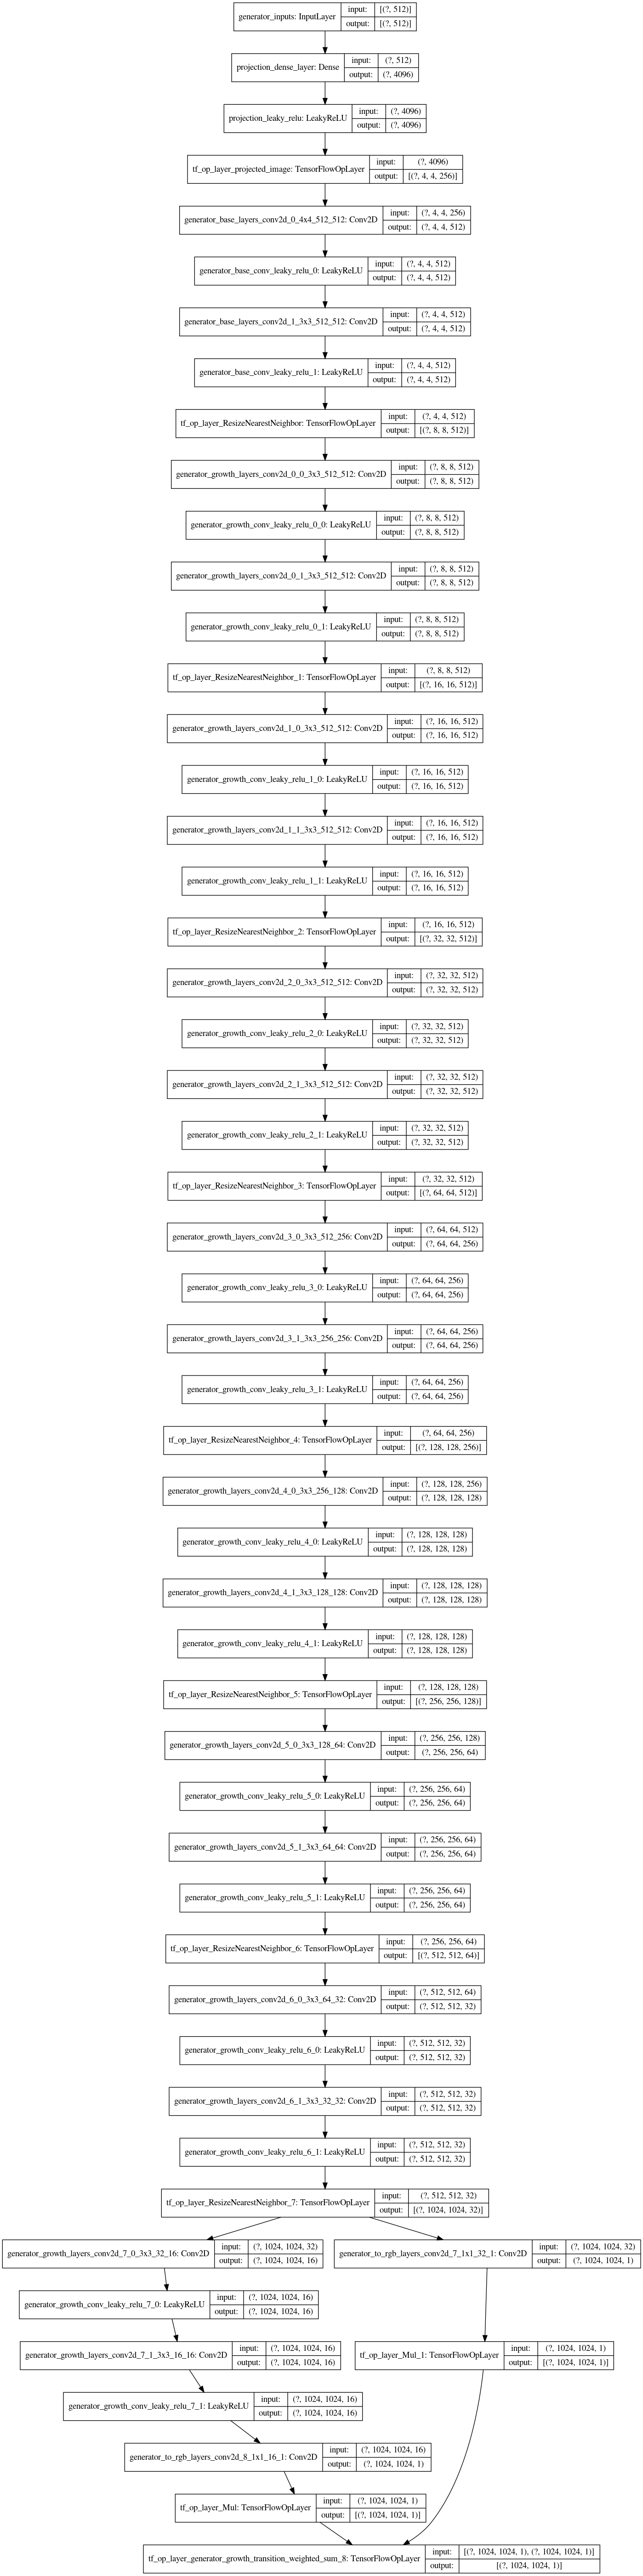

In [13]:
# Plot generator model.
tf.keras.utils.plot_model(
    model=generator_model,
    to_file="generator_model.png",
    show_shapes=True,
    show_layer_names=True
)

In [14]:
generator_model.__dict__

{'_self_setattr_tracking': True,
 '_trainable': True,
 '_stateful': False,
 'built': True,
 '_build_input_shape': TensorShape([None, 512]),
 '_saved_model_inputs_spec': TensorSpec(shape=(None, 512), dtype=tf.float32, name='generator_inputs'),
 '_input_spec': None,
 '_supports_masking': True,
 '_name': 'generator_growth_transition_8',
 '_activity_regularizer': None,
 '_trainable_weights': [],
 '_non_trainable_weights': [],
 '_updates': [],
 '_thread_local': <_thread._local at 0x7f068044eb90>,
 '_callable_losses': [],
 '_losses': [],
 '_metrics': [],
 '_metrics_lock': <unlocked _thread.lock object at 0x7f0680459630>,
 '_dtype_policy': <Policy "float32", loss_scale=None>,
 '_dtype_defaulted_to_floatx': True,
 '_compute_dtype_object': tf.float32,
 '_autocast': False,
 '_layers': [<tensorflow.python.keras.engine.input_layer.InputLayer at 0x7f0696ee0450>,
 '_inbound_nodes': [],
 '_outbound_nodes': [],
 '_expects_training_arg': True,
 '_default_training_arg': None,
 '_expects_mask_arg': True,

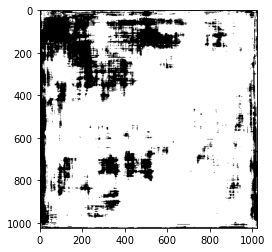

In [15]:
noise = tf.random.normal(shape=[10, arguments["latent_size"]])
fake_images = generator_model(inputs=noise, training=False)

plt.imshow(fake_images[0, :, :, 0], cmap='gray')

## discriminators.py

In [16]:
class Discriminator(object):
    """Discriminator that takes image input and outputs logits.

    Fields:
        name: str, name of `Discriminator`.
        kernel_regularizer: `l1_l2_regularizer` object, regularizar for
            kernel variables.
        bias_regularizer: `l1_l2_regularizer` object, regularizar for bias
            variables.
        params: dict, user passed parameters.
        alpha_var: variable, alpha for weighted sum of fade-in of layers.
        from_rgb_conv_layers: list, `Conv2D` fromRGB layers.
        from_rgb_leaky_relu_layers: list, leaky relu layers that follow
            `Conv2D` fromRGB layers.
        conv_layers: list, `Conv2D` layers.
        leaky_relu_layers: list, leaky relu layers that follow `Conv2D`
            layers.
        growing_downsample_layers: list, `AveragePooling2D` layers for growing
            branch.
        shrinking_downsample_layers: list, `AveragePooling2D` layers for
            shrinking branch.
        flatten_layer: `Flatten` layer, flattens image for logits layer.
        logits_layer: `Dense` layer, used for calculating logits.
        model: instance of discriminator `Model`.
    """
    def __init__(
        self,
        kernel_regularizer,
        bias_regularizer,
        name,
        params,
        alpha_var
    ):
        """Instantiates and builds discriminator network.

        Args:
            kernel_regularizer: `l1_l2_regularizer` object, regularizar for
                kernel variables.
            bias_regularizer: `l1_l2_regularizer` object, regularizar for bias
                variables.
            name: str, name of discriminator.
            params: dict, user passed parameters.
            alpha_var: variable, alpha for weighted sum of fade-in of layers.
        """
        # Set name of discriminator.
        self.name = name

        # Store regularizers.
        self.kernel_regularizer = kernel_regularizer
        self.bias_regularizer = bias_regularizer

        # Store parameters.
        self.params = params

        # Store reference to alpha variable.
        self.alpha_var = alpha_var

        # Store lists of layers.
        self.from_rgb_conv_layers = []
        self.from_rgb_leaky_relu_layers = []

        self.conv_layers = []
        self.leaky_relu_layers = []

        self.growing_downsample_layers = []
        self.shrinking_downsample_layers = []

        self.flatten_layer = None
        self.logits_layer = None

        # Instantiate discriminator layers.
        self._create_discriminator_layers()

        # Store current discriminator model.
        self.model = None

    def _create_from_rgb_layers(self):
        """Creates discriminator fromRGB layers of 1x1 convs.

        Returns:
            List of fromRGB 1x1 conv layers and leaky relu layers.
        """
        # Get fromRGB layer properties.
        from_rgb = [
            self.params["discriminator_from_rgb_layers"][i][0][:]
            for i in range(
                len(self.params["discriminator_from_rgb_layers"])
            )
        ]

        # Create list to hold toRGB 1x1 convs.
        from_rgb_conv_layers = [
            tf.keras.layers.Conv2D(
                filters=from_rgb[i][3],
                kernel_size=from_rgb[i][0:2],
                strides=from_rgb[i][4:6],
                padding="same",
                activation=None,
                kernel_initializer=(
                    tf.random_normal_initializer(mean=0., stddev=1.0)
#                     if params["use_equalized_learning_rate"]
#                     else "he_normal"
                ),
                kernel_regularizer=self.kernel_regularizer,
                bias_regularizer=self.bias_regularizer,
#                 equalized_learning_rate=params["use_equalized_learning_rate"],
                name="{}_from_rgb_layers_conv2d_{}_{}x{}_{}_{}".format(
                    self.name,
                    i,
                    from_rgb[i][0],
                    from_rgb[i][1],
                    from_rgb[i][2],
                    from_rgb[i][3]
                )
            )
            for i in range(len(from_rgb))
        ]

        from_rgb_leaky_relu_layers = [
            tf.keras.layers.LeakyReLU(
                alpha=self.params["discriminator_leaky_relu_alpha"],
                name="{}_from_rgb_conv_leaky_relu_{}".format(self.name, i)
            )
            for i in range(len(from_rgb))
        ]

        return from_rgb_conv_layers, from_rgb_leaky_relu_layers

    def _create_base_conv_layer_block(self):
        """Creates discriminator base conv layer block.

        Returns:
            List of base block conv layers and list of leaky relu layers.
        """
        # Get conv block layer properties.
        conv_block = self.params["discriminator_base_conv_blocks"][0]

        # Create list of base conv layers.
        base_conv_layers = [
            tf.keras.layers.Conv2D(
                filters=conv_block[i][3],
                kernel_size=conv_block[i][0:2],
                strides=conv_block[i][4:6],
                padding="same",
                activation=None,
                kernel_initializer=(
                    tf.random_normal_initializer(mean=0., stddev=1.0)
#                     if params["use_equalized_learning_rate"]
#                     else "he_normal"
                ),
                kernel_regularizer=self.kernel_regularizer,
                bias_regularizer=self.bias_regularizer,
#                 equalized_learning_rate=params["use_equalized_learning_rate"],
                name="{}_base_layers_conv2d_{}_{}x{}_{}_{}".format(
                    self.name,
                    i,
                    conv_block[i][0],
                    conv_block[i][1],
                    conv_block[i][2],
                    conv_block[i][3]
                )
            )
            for i in range(len(conv_block) - 1)
        ]

        # Have valid padding for layer just before flatten and logits.
        base_conv_layers.append(
            tf.keras.layers.Conv2D(
                filters=conv_block[-1][3],
                kernel_size=conv_block[-1][0:2],
                strides=conv_block[-1][4:6],
                padding="valid",
                activation=None,
                kernel_initializer=(
                    tf.random_normal_initializer(mean=0., stddev=1.0)
#                     if params["use_equalized_learning_rate"]
#                     else "he_normal"
                ),
                kernel_regularizer=self.kernel_regularizer,
                bias_regularizer=self.bias_regularizer,
#                 equalized_learning_rate=params["use_equalized_learning_rate"],
                name="{}_base_layers_conv2d_{}_{}x{}_{}_{}".format(
                    self.name,
                    len(conv_block) - 1,
                    conv_block[-1][0],
                    conv_block[-1][1],
                    conv_block[-1][2],
                    conv_block[-1][3]
                )
            )
        )

        base_leaky_relu_layers = [
            tf.keras.layers.LeakyReLU(
                alpha=self.params["discriminator_leaky_relu_alpha"],
                name="{}_base_conv_leaky_relu_{}".format(self.name, i)
            )
            for i in range(len(conv_block))
        ]

        return base_conv_layers, base_leaky_relu_layers

    def _create_growth_conv_layer_block(self, block_idx):
        """Creates discriminator growth conv layer block.

        Args:
            block_idx: int, the current growth block's index.

        Returns:
            List of growth block's conv layers and list of growth block's
                leaky relu layers.
        """
        # Get conv block layer properties.
        conv_block = self.params["discriminator_growth_conv_blocks"][block_idx]

        # Create new growth convolutional layers.
        growth_conv_layers = [
            tf.keras.layers.Conv2D(
                filters=conv_block[i][3],
                kernel_size=conv_block[i][0:2],
                strides=conv_block[i][4:6],
                padding="same",
                activation=None,
                kernel_initializer=(
                    tf.random_normal_initializer(mean=0., stddev=1.0)
#                     if params["use_equalized_learning_rate"]
#                     else "he_normal"
                ),
                kernel_regularizer=self.kernel_regularizer,
                bias_regularizer=self.bias_regularizer,
#                 equalized_learning_rate=params["use_equalized_learning_rate"],
                name="{}_growth_layers_conv2d_{}_{}_{}x{}_{}_{}".format(
                    self.name,
                    block_idx,
                    i,
                    conv_block[i][0],
                    conv_block[i][1],
                    conv_block[i][2],
                    conv_block[i][3]
                )
            )
            for i in range(len(conv_block))
        ]

        growth_leaky_relu_layers = [
            tf.keras.layers.LeakyReLU(
                alpha=self.params["discriminator_leaky_relu_alpha"],
                name="{}_growth_conv_leaky_relu_{}_{}".format(
                    self.name, block_idx, i
                )
            )
            for i in range(len(conv_block))
        ]

        return growth_conv_layers, growth_leaky_relu_layers

    def _create_downsample_layers(self):
        """Creates discriminator downsample layers.

        Returns:
            Lists of AveragePooling2D layers for growing and shrinking
                branches.
        """
        # Create list to hold growing branch's downsampling layers.
        growing_downsample_layers = [
            tf.keras.layers.AveragePooling2D(
                pool_size=(2, 2),
                strides=(2, 2),
                name="{}_growing_average_pooling_2d_{}".format(
                    self.name, i - 1
                )
            )
            for i in range(
                1, len(self.params["discriminator_from_rgb_layers"])
            )
        ]

        # Create list to hold shrinking branch's downsampling layers.
        shrinking_downsample_layers = [
            tf.keras.layers.AveragePooling2D(
                pool_size=(2, 2),
                strides=(2, 2),
                name="{}_shrinking_average_pooling_2d_{}".format(
                    self.name, i - 1
                )
            )
            for i in range(
                1, len(self.params["discriminator_from_rgb_layers"])
            )
        ]

        return growing_downsample_layers, shrinking_downsample_layers

    def _create_discriminator_layers(self):
        """Creates discriminator layers.

        Args:
            input_shape: tuple, shape of latent vector input of shape
                [batch_size, latent_size].
        """
        (self.from_rgb_conv_layers,
         self.from_rgb_leaky_relu_layers) = self._create_from_rgb_layers()

        (base_conv_layers,
         base_leaky_relu_layers) = self._create_base_conv_layer_block()
        self.conv_layers.append(base_conv_layers)
        self.leaky_relu_layers.append(base_leaky_relu_layers)

        for block_idx in range(
            len(self.params["discriminator_growth_conv_blocks"])
        ):
            (growth_conv_layers,
             growth_leaky_relu_layers
             ) = self._create_growth_conv_layer_block(block_idx)

            self.conv_layers.append(growth_conv_layers)
            self.leaky_relu_layers.append(growth_leaky_relu_layers)

        (self.growing_downsample_layers,
         self.shrinking_downsample_layers) = self._create_downsample_layers()

        self.flatten_layer = tf.keras.layers.Flatten()

        self.logits_layer = tf.keras.layers.Dense(
            units=1,
            activation=None,
            kernel_initializer=(
                tf.random_normal_initializer(mean=0., stddev=1.0)
#                 if params["use_equalized_learning_rate"]
#                 else "he_normal"
            ),
            kernel_regularizer=self.kernel_regularizer,
            bias_regularizer=self.bias_regularizer,
            name="{}_layers_dense_logits".format(self.name)
        )

#         print(
#             {
#                 "from_rgb_conv_layers": self.from_rgb_conv_layers,
#                 "from_rgb_leaky_relu_layers": self.from_rgb_leaky_relu_layers,
#                 "conv_layers": self.conv_layers,
#                 "leaky_relu_layers": self.leaky_relu_layers,
#                 "growing_downsample_layers": self.growing_downsample_layers,
#                 "shrinking_downsample_layers": self.shrinking_downsample_layers,
#                 "flatten_layer": self.flatten_layer,
#                 "logits_layer": self.logits_layer
#             }
#         )
#         print("\n")

    def _use_logits_layer(self, inputs):
        """Uses flatten and logits layers to get logits tensor.

        Args:
            inputs: tensor, output of last conv layer of discriminator.

        Returns:
            Final logits tensor of discriminator.
        """
        # Set shape to remove ambiguity for dense layer.
        inputs.set_shape(
            [
                inputs.get_shape()[0],
                self.params["generator_projection_dims"][0] // 4,
                self.params["generator_projection_dims"][1] // 4,
                inputs.get_shape()[-1]]
        )

        # Flatten final block conv tensor.
        flat_inputs = self.flatten_layer(inputs=inputs)

        # Final linear layer for logits.
        logits = self.logits_layer(inputs=flat_inputs)

        return logits

    def _create_base_block_and_logits(self, inputs):
        """Creates base discriminator block and logits.

        Args:
            block_conv: tensor, output of previous `Conv2D` block's layer.

        Returns:
            Final logits tensor of discriminator.
        """
        # Only need the first conv layer block for base network.
        base_conv_layers = self.conv_layers[0]
        base_leaky_relu_layers = self.leaky_relu_layers[0]

        network = inputs
        for i in range(len(base_conv_layers)):
            network = base_conv_layers[i](inputs=network)
            network = base_leaky_relu_layers[i](inputs=network)

        # Get logits now.
        logits = self._use_logits_layer(inputs=network)

        return logits

    def _create_growth_transition_weighted_sum(self, inputs, block_idx):
        """Creates growth transition img_to_vec weighted_sum.

        Args:
            inputs: tensor, input image to discriminator.
            block_idx: int, current block index of model progression.

        Returns:
            Tensor of weighted sum between shrinking and growing block paths.
        """
        # Growing side chain.
        growing_from_rgb_conv_layer = self.from_rgb_conv_layers[block_idx]
        growing_from_rgb_leaky_relu_layer = (
            self.from_rgb_leaky_relu_layers[block_idx]
        )
        growing_downsample_layer = (
            self.growing_downsample_layers[block_idx - 1]
        )

        growing_conv_layers = self.conv_layers[block_idx]
        growing_leaky_relu_layers = self.leaky_relu_layers[block_idx]

        # Pass inputs through layer chain.
        network = growing_from_rgb_conv_layer(inputs=inputs)
        network = growing_from_rgb_leaky_relu_layer(inputs=network)

        for i in range(len(growing_conv_layers)):
            network = growing_conv_layers[i](inputs=network)
            network = growing_leaky_relu_layers[i](inputs=network)

        # Down sample from 2s X 2s to s X s image.
        growing_network = growing_downsample_layer(inputs=network)

        # Shrinking side chain.
        shrinking_from_rgb_conv_layer = (
            self.from_rgb_conv_layers[block_idx - 1]
        )
        shrinking_from_rgb_leaky_relu_layer = (
            self.from_rgb_leaky_relu_layers[block_idx - 1]
        )
        shrinking_downsample_layer = (
            self.shrinking_downsample_layers[block_idx - 1]
        )

        # Pass inputs through layer chain.
        # Down sample from 2s X 2s to s X s image.
        network = shrinking_downsample_layer(inputs=inputs)

        network = shrinking_from_rgb_conv_layer(inputs=network)
        shrinking_network = shrinking_from_rgb_leaky_relu_layer(
            inputs=network
        )

        # Weighted sum.
        weighted_sum = tf.add(
            x=growing_network * self.alpha_var,
            y=shrinking_network * (1.0 - self.alpha_var),
            name="{}_growth_transition_weighted_sum_{}".format(
                self.name, block_idx
            )
        )

        return weighted_sum

    def _create_perm_growth_block_network(self, inputs, block_idx):
        """Creates discriminator permanent block network.

        Args:
            inputs: tensor, output of previous block's layer.
            block_idx: int, current block index of model progression.

        Returns:
            Tensor from final permanent block `Conv2D` layer.
        """
        # Get permanent growth blocks, so skip the base block.
        permanent_conv_layers = self.conv_layers[1:block_idx]
        permanent_leaky_relu_layers = self.leaky_relu_layers[1:block_idx]
        permanent_downsample_layers = self.growing_downsample_layers[0:block_idx - 1]

        # Reverse order of blocks.
        permanent_conv_layers = permanent_conv_layers[::-1]
        permanent_leaky_relu_layers = permanent_leaky_relu_layers[::-1]
        permanent_downsample_layers = permanent_downsample_layers[::-1]

        # Pass inputs through layer chain.
        network = inputs

        # Loop through the permanent growth blocks.
        for i in range(len(permanent_conv_layers)):
            # Get layers from ith permanent block.
            conv_layers = permanent_conv_layers[i]
            leaky_relu_layers = permanent_leaky_relu_layers[i]
            permanent_downsample_layer = permanent_downsample_layers[i]

            # Loop through layers of ith permanent block.
            for j in range(len(conv_layers)):
                network = conv_layers[j](inputs=network)
                network = leaky_relu_layers[j](inputs=network)

            # Down sample from 2s X 2s to s X s image.
            network = permanent_downsample_layer(inputs=network)

        return network

    def _build_base_model(self, input_shape):
        """Builds discriminator base model.

        Args:
            input_shape: tuple, shape of image vector input of shape
                [batch_size, height, width, depth].

        Returns:
            Instance of `Model` object.
        """
        # Create the input layer to discriminator.
        # shape = (batch_size, height, width, depth)
        inputs = tf.keras.Input(
            shape=input_shape, name="{}_inputs".format(self.name)
        )

        # Only need the first fromRGB conv layer & block for base network.
        base_from_rgb_conv_layer = self.from_rgb_conv_layers[0]
        base_from_rgb_leaky_relu_layer = self.from_rgb_leaky_relu_layers[0]

        base_conv_layers = self.conv_layers[0]
        base_leaky_relu_layers = self.leaky_relu_layers[0]

        # Pass inputs through layer chain.
        network = base_from_rgb_conv_layer(inputs=inputs)
        network = base_from_rgb_leaky_relu_layer(inputs=network)

        # Get logits after continuing through base conv block.
        logits = self._create_base_block_and_logits(inputs=network)

        # Define model.
        model = tf.keras.Model(
            inputs=inputs,
            outputs=logits,
            name="{}_base".format(self.name)
        )

        return model

    def _build_growth_transition_model(self, input_shape, block_idx):
        """Builds discriminator growth transition model.

        Args:
            input_shape: tuple, shape of latent vector input of shape
                [batch_size, height, width, depth].
            block_idx: int, current block index of model progression.

        Returns:
            Instance of `Model` object.
        """
        # Create the input layer to discriminator.
        # shape = (batch_size, height, width, depth)
        inputs = tf.keras.Input(
            shape=input_shape, name="{}_inputs".format(self.name)
        )

        # Get weighted sum between shrinking and growing block paths.
        weighted_sum = self._create_growth_transition_weighted_sum(
            inputs=inputs, block_idx=block_idx
        )

        # Get output of final permanent growth block's last `Conv2D` layer.
        network = self._create_perm_growth_block_network(
            inputs=weighted_sum, block_idx=block_idx
        )

        # Get logits after continuing through base conv block.
        logits = self._create_base_block_and_logits(inputs=network)

        # Define model.
        model = tf.keras.Model(
            inputs=inputs,
            outputs=logits,
            name="{}_growth_transition_{}".format(self.name, block_idx)
        )

        return model

    def _build_growth_stable_model(self, input_shape, block_idx):
        """Builds generator growth stable model.

        Args:
            input_shape: tuple, shape of latent vector input of shape
                [batch_size, latent_size].
            block_idx: int, current block index of model progression.

        Returns:
            Instance of `Model` object.
        """
        # Create the input layer to generator.
        # shape = (batch_size, latent_size)
        inputs = tf.keras.Input(
            shape=input_shape, name="{}_inputs".format(self.name)
        )

        # Get fromRGB layers.
        from_rgb_conv_layer = self.from_rgb_conv_layers[block_idx]
        from_rgb_leaky_relu_layer = self.from_rgb_leaky_relu_layers[block_idx]

        # Pass inputs through layer chain.
        network = from_rgb_conv_layer(inputs=inputs)
        network = from_rgb_leaky_relu_layer(inputs=network)

        # Get output of final permanent growth block's last `Conv2D` layer.
        network = self._create_perm_growth_block_network(
            inputs=network, block_idx=block_idx + 1
        )

        # Get logits after continuing through base conv block.
        logits = self._create_base_block_and_logits(inputs=network)

        # Define model.
        model = tf.keras.Model(
            inputs=inputs,
            outputs=logits,
            name="{}_growth_stable_{}".format(self.name, block_idx)
        )

        return model

    def get_model(self, input_shape, growth_idx):
        """Returns discriminator's `Model` object.

        Args:
            input_shape: tuple, shape of image input of shape
                [batch_size, height, width, depth].
            growth_idx: int, index of current growth stage.
                0 = base,
                odd = growth transition,
                even = growth stability.

        Returns:
            Discriminator's `Model` object.
        """
        block_idx = (growth_idx + 1) // 2
        if growth_idx == 0:
            self.model = self._build_base_model(input_shape)
        elif growth_idx % 2 == 1:
            self.model = self._build_growth_transition_model(
                input_shape, block_idx
            )
        elif growth_idx % 2 == 0:
            self.model = self._build_growth_stable_model(
                input_shape, block_idx
            )
        else:
            print("ERROR: Bad growth index!")

        return self.model

    def get_discriminator_loss(
        self,
        global_batch_size,
        fake_logits,
        real_logits,
        global_step,
        summary_file_writer
    ):
        """Gets discriminator loss.

        Args:
            global_batch_size: int, global batch size for distribution.
            fake_logits: tensor, shape of
                [batch_size, 1].
            real_logits: tensor, shape of
                [batch_size, 1].
            global_step: int, current global step for training.
            summary_file_writer: summary file writer.

        Returns:
            Tensor of discriminator's total loss of shape [].
        """
        if self.params["distribution_strategy"]:
            # Calculate base discriminator loss.
            discriminator_real_loss = tf.nn.compute_average_loss(
                per_example_loss=tf.keras.losses.BinaryCrossentropy(
                    from_logits=True,
                    label_smoothing=self.params["label_smoothing"],
                    reduction=tf.keras.losses.Reduction.NONE
                )(
                    y_true=tf.ones_like(input=real_logits), y_pred=real_logits
                ),
                global_batch_size=global_batch_size
            )

            discriminator_fake_loss = tf.nn.compute_average_loss(
                per_example_loss=tf.keras.losses.BinaryCrossentropy(
                    from_logits=True,
                    reduction=tf.keras.losses.Reduction.NONE
                )(
                    y_true=tf.zeros_like(input=fake_logits), y_pred=fake_logits
                ),
                global_batch_size=global_batch_size
            )
        else:
            # Calculate base discriminator loss.
            discriminator_real_loss = tf.keras.losses.BinaryCrossentropy(
                from_logits=True,
                label_smoothing=self.params["label_smoothing"]
            )(
                y_true=tf.ones_like(input=real_logits), y_pred=real_logits
            )

            discriminator_fake_loss = tf.keras.losses.BinaryCrossentropy(
                from_logits=True
            )(
                y_true=tf.zeros_like(input=fake_logits), y_pred=fake_logits
            )

        discriminator_loss = tf.math.add(
            x=discriminator_real_loss,
            y=discriminator_fake_loss,
            name="discriminator_loss"
        )

        if self.params["distribution_strategy"]:
            # Get regularization losses.
            discriminator_reg_loss = tf.nn.scale_regularization_loss(
                regularization_loss=sum(self.model.losses)
            )
        else:
            # Get regularization losses.
            discriminator_reg_loss = sum(self.model.losses)

        # Combine losses for total losses.
        discriminator_total_loss = tf.math.add(
            x=discriminator_loss,
            y=discriminator_reg_loss,
            name="discriminator_total_loss"
        )

        if self.params["write_summaries"]:
            # Add summaries for TensorBoard.
            with summary_file_writer.as_default():
                with tf.summary.record_if(
                    condition=tf.equal(
                        x=tf.math.floormod(
                            x=global_step,
                            y=self.params["save_summary_steps"]
                        ), y=0
                    )
                ):
                    tf.summary.scalar(
                        name="losses/discriminator_real_loss",
                        data=discriminator_real_loss,
                        step=global_step
                    )
                    tf.summary.scalar(
                        name="losses/discriminator_fake_loss",
                        data=discriminator_fake_loss,
                        step=global_step
                    )
                    tf.summary.scalar(
                        name="losses/discriminator_loss",
                        data=discriminator_loss,
                        step=global_step
                    )
                    tf.summary.scalar(
                        name="losses/discriminator_reg_loss",
                        data=discriminator_reg_loss,
                        step=global_step
                    )
                    tf.summary.scalar(
                        name="optimized_losses/discriminator_total_loss",
                        data=discriminator_total_loss,
                        step=global_step
                    )
                    summary_file_writer.flush()

        return discriminator_total_loss


In [17]:
# Instantiate discriminator.
pgan_discriminator = Discriminator(
    kernel_regularizer=tf.keras.regularizers.l1_l2(
        l1=arguments["discriminator_l1_regularization_scale"],
        l2=arguments["discriminator_l2_regularization_scale"]
    ),
    bias_regularizer=None,
    name="discriminator",
    params=arguments,
    alpha_var=tf.Variable(
        initial_value=tf.zeros(shape=[], dtype=tf.float32),
        trainable=False,
        name="alpha_var"
    )
)

# Define discriminator model.
multiplier = 8
height, width = arguments["generator_projection_dims"][0:2]
discriminator_model = pgan_discriminator.get_model(
    input_shape=(
        height * (2 ** multiplier),
        width * (2 ** multiplier),
        arguments["depth"]
    ),
    growth_idx=15
)

In [18]:
# Summarize discriminator model.
discriminator_model.summary()

Model: "discriminator_growth_transition_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
discriminator_inputs (InputLaye [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
discriminator_from_rgb_layers_c (None, 1024, 1024, 1 32          discriminator_inputs[0][0]       
__________________________________________________________________________________________________
discriminator_from_rgb_conv_lea (None, 1024, 1024, 1 0           discriminator_from_rgb_layers_con
__________________________________________________________________________________________________
discriminator_growth_layers_con (None, 1024, 1024, 1 2320        discriminator_from_rgb_conv_leaky
__________________________________________________________________

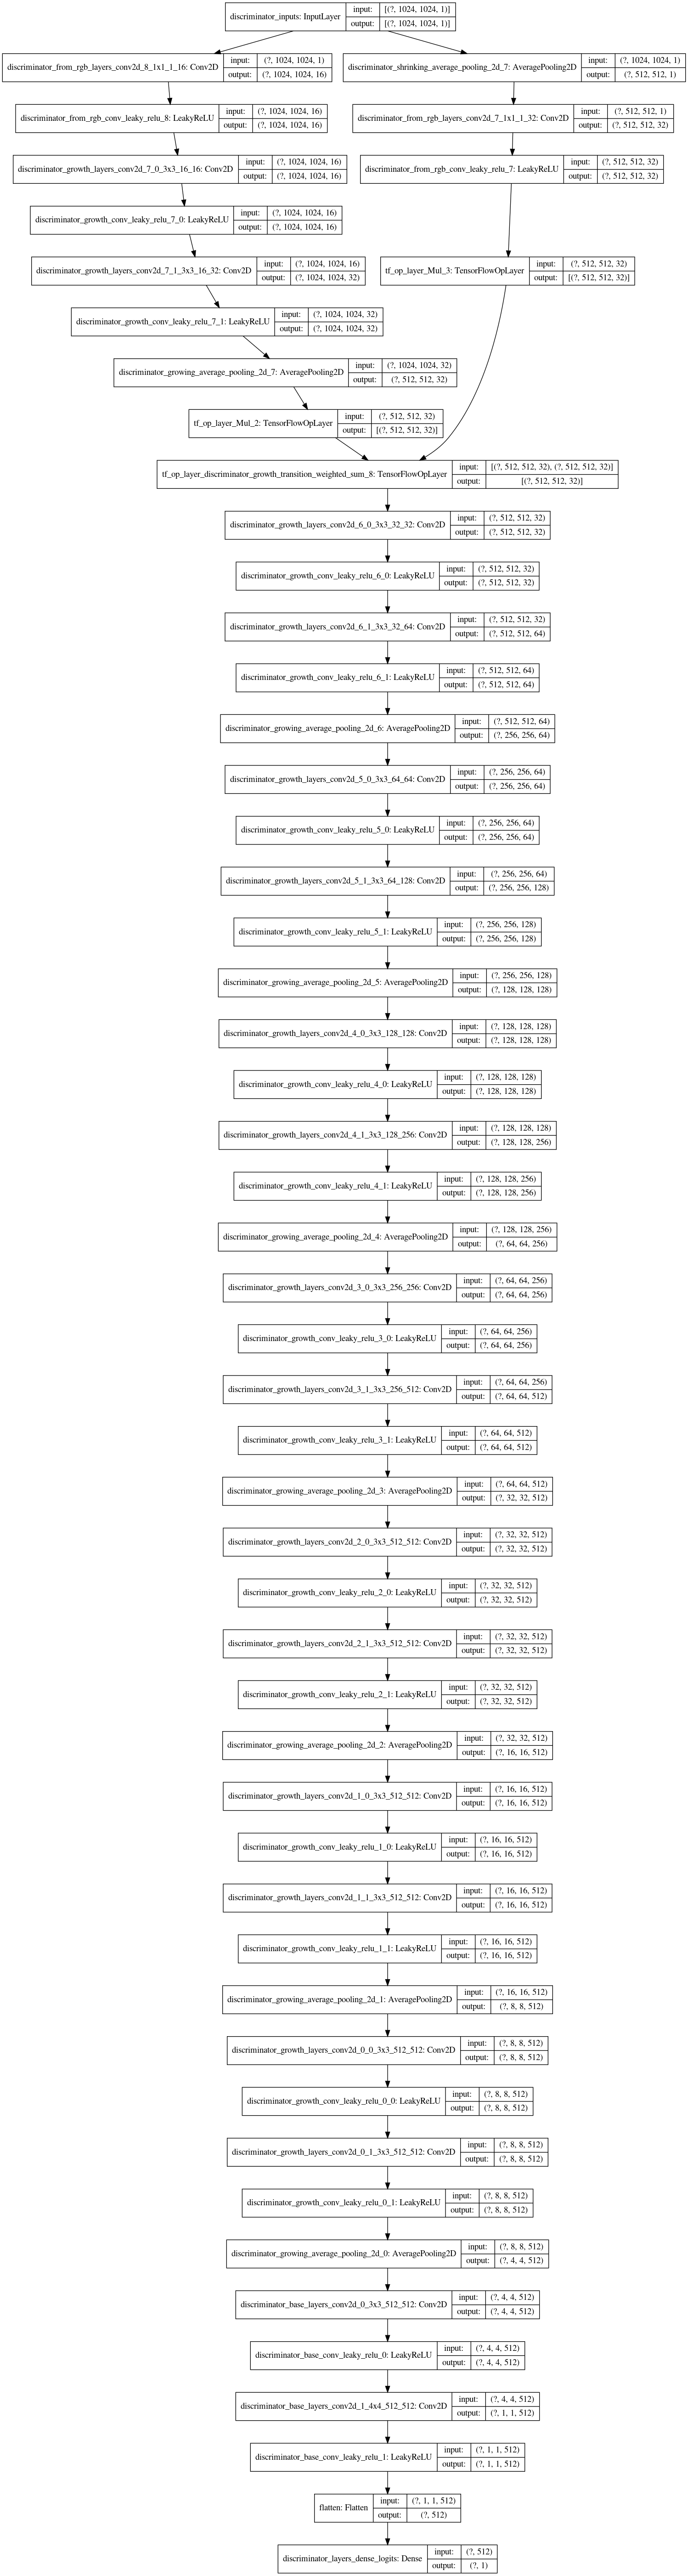

In [19]:
# Plot discriminator model.
tf.keras.utils.plot_model(
    model=discriminator_model,
    to_file="discriminator_model.png",
    show_shapes=True,
    show_layer_names=True
)

In [20]:
discriminator_model.__dict__

{'_self_setattr_tracking': True,
 '_trainable': True,
 '_stateful': False,
 'built': True,
 '_build_input_shape': TensorShape([None, 1024, 1024, 1]),
 '_saved_model_inputs_spec': TensorSpec(shape=(None, 1024, 1024, 1), dtype=tf.float32, name='discriminator_inputs'),
 '_input_spec': None,
 '_supports_masking': True,
 '_name': 'discriminator_growth_transition_8',
 '_activity_regularizer': None,
 '_trainable_weights': [],
 '_non_trainable_weights': [],
 '_updates': [],
 '_thread_local': <_thread._local at 0x7f070d321170>,
 '_callable_losses': [],
 '_losses': [],
 '_metrics': [],
 '_metrics_lock': <unlocked _thread.lock object at 0x7f070d270990>,
 '_dtype_policy': <Policy "float32", loss_scale=None>,
 '_dtype_defaulted_to_floatx': True,
 '_compute_dtype_object': tf.float32,
 '_autocast': False,
 '_layers': [<tensorflow.python.keras.engine.input_layer.InputLayer at 0x7f070d38d7d0>,
 '_inbound_nodes': [],
 '_outbound_nodes': [],
 '_expects_training_arg': True,
 '_default_training_arg': None,

In [21]:
images = tf.random.normal(
    shape=[
        10,
        height * (2 ** multiplier),
        width * (2 ** multiplier),
        arguments["depth"]
    ]
)
logits = discriminator_model(inputs=images, training=False)
logits.shape

TensorShape([10, 1])

## train_and_evaluate_loop.py

In [27]:
class TrainAndEvaluateLoop(object):
    """Train and evaluate loop trainer.

    Fields:
        params: dict, user passed parameters.
        network_objects: dict, instances of `Generator` and `Discriminator`
            network objects.
        network_models: dict, instances of Keras `Model`s for each network.
        optimizers: dict, instances of Keras `Optimizer`s for each network.
        strategy: instance of tf.distribute.strategy.
        global_batch_size: int, the global batch size after summing batch
            sizes across replicas.
        global_step: tf.Variable, the global step counter across epochs and
            steps within epoch.
        checkpoint_manager: instance of `tf.train.CheckpointManager`.
        summary_file_writer: instance of tf.summary.create_file_writer for
            summaries for TensorBoard.
        alpha_var: tf.Variable, used in growth transition network's weighted
            sum.
        growth_idx: int, current growth index model has progressed to.
    """
    def __init__(self, params):
        """Instantiate trainer.

        Args:
            params: dict, user passed parameters.
        """
        self.params = params

        self.network_objects = {}
        self.network_models = {}
        self.optimizers = {}

        self.strategy = None

        self.global_batch_size = None
        self.global_step = tf.Variable(
            initial_value=tf.zeros(shape=[], dtype=tf.int64),
            trainable=False,
            name="global_step"
        )
        self.checkpoint_manager = None
        self.summary_file_writer = None

        self.alpha_var = tf.Variable(
            initial_value=tf.zeros(shape=[], dtype=tf.float32),
            trainable=False,
            name="alpha_var"
        )
        self.growth_idx = 0

    @tf.function
    def increment_global_step(self):
        self.global_step.assign_add(
            delta=tf.ones(shape=[], dtype=tf.int64)
        )

    @tf.function
    def increment_alpha_var(self):
        self.alpha_var.assign(
            value=tf.divide(
                x=tf.cast(
                    # Add 1 since it trains on global step 0, so off by 1.
                    x=tf.add(
                        x=tf.math.floormod(
                            x=self.global_step,
                            y=self.params["num_steps_until_growth"]
                        ),
                        y=1
                    ),
                    dtype=tf.float32
                ),
                y=self.params["num_steps_until_growth"]
            )
        )

    # train_and_eval.py
    def generator_loss_phase(self, mode, training):
        """Gets fake logits and loss for generator.

        Args:
            mode: str, what mode currently in: TRAIN or EVAL.
            training: bool, if model should be training.

        Returns:
            Fake logits of shape [batch_size, 1] and generator loss of shape
                [].
        """
        batch_size = (
            self.params["train_batch_size"]
            if mode == "TRAIN"
            else self.params["eval_batch_size"]
        )

        # Create random noise latent vector for each batch example.
        Z = tf.random.normal(
            shape=[batch_size, self.params["latent_size"]],
            mean=0.0,
            stddev=1.0,
            dtype=tf.float32
        )

        # Get generated image from generator network from gaussian noise.
        fake_images = self.network_models["generator"](
            inputs=Z, training=training
        )

        if self.params["write_summaries"] and mode == "TRAIN":
            # Add summaries for TensorBoard.
            with self.summary_file_writer.as_default():
                with tf.summary.record_if(
                condition=tf.equal(
                    x=tf.math.floormod(
                        x=self.global_step,
                        y=self.params["save_summary_steps"]
                    ), y=0
                )
                ):
                    tf.summary.image(
                        name="fake_images",
                        data=fake_images,
                        step=self.global_step,
                        max_outputs=5
                    )
                    self.summary_file_writer.flush()

        # Get fake logits from discriminator using generator's output image.
        fake_logits = self.network_models["discriminator"](
            inputs=fake_images, training=training
        )

        # Get generator total loss.
        generator_total_loss = (
            self.network_objects["generator"].get_generator_loss(
                global_batch_size=self.global_batch_size,
                fake_logits=fake_logits,
                global_step=self.global_step,
                summary_file_writer=self.summary_file_writer
            )
        )

        return fake_logits, generator_total_loss

    def discriminator_loss_phase(self, real_images, fake_logits, training):
        """Gets real logits and loss for discriminator.

        Args:
            real_images: tensor, real images of shape
                [batch_size, height * width * depth].
            fake_logits: tensor, discriminator logits of fake images of shape
                [batch_size, 1].
            training: bool, if in training mode.

        Returns:
            Real logits of shape [batch_size, 1] and discriminator loss of
                shape [].
        """
        # Get real logits from discriminator using real image.
        real_logits = self.network_models["discriminator"](
            inputs=real_images, training=training
        )

        # Get discriminator total loss.
        discriminator_total_loss = (
            self.network_objects["discriminator"].get_discriminator_loss(
                global_batch_size=self.global_batch_size,
                fake_logits=fake_logits,
                real_logits=real_logits,
                global_step=self.global_step,
                summary_file_writer=self.summary_file_writer
            )
        )

        return real_logits, discriminator_total_loss

    # train.py
    def get_variables_and_gradients(self, loss, gradient_tape, scope):
        """Gets variables and gradients from model wrt. loss.

        Args:
            loss: tensor, shape of [].
            gradient_tape: instance of `GradientTape`.
            scope: str, the name of the network of interest.

        Returns:
            Lists of network's variables and gradients.
        """
        # Get trainable variables.
        variables = self.network_models[scope].trainable_variables

        # Get gradients from gradient tape.
        gradients = gradient_tape.gradient(
            target=loss, sources=variables
        )

        # Clip gradients.
        if self.params["{}_clip_gradients".format(scope)]:
            gradients, _ = tf.clip_by_global_norm(
                t_list=gradients,
                clip_norm=params["{}_clip_gradients".format(scope)],
                name="{}_clip_by_global_norm_gradients".format(scope)
            )

        # Add variable names back in for identification.
        gradients = [
            tf.identity(
                input=g,
                name="{}_{}_gradients".format(scope, v.name[:-2])
            )
            if tf.is_tensor(x=g) else g
            for g, v in zip(gradients, variables)
        ]

        return variables, gradients

    def create_variable_and_gradient_histogram_summaries(
        self, variables, gradients, scope
    ):
        """Creates variable and gradient histogram summaries.

        Args:
            variables: list, network's trainable variables.
            gradients: list, gradients of network's trainable variables wrt.
                loss.
            scope: str, the name of the network of interest.
        """
        if self.params["write_summaries"]:
            # Add summaries for TensorBoard.
            with self.summary_file_writer.as_default():
                with tf.summary.record_if(
                    condition=tf.equal(
                        x=tf.math.floormod(
                            x=self.global_step,
                            y=self.params["save_summary_steps"]
                        ), y=0
                    )
                ):
                    for v, g in zip(variables, gradients):
                        tf.summary.histogram(
                            name="{}_variables/{}".format(
                                scope, v.name[:-2]
                            ),
                            data=v,
                            step=self.global_step
                        )
                        if tf.is_tensor(x=g):
                            tf.summary.histogram(
                                name="{}_gradients/{}".format(
                                    scope, v.name[:-2]
                                ),
                                data=g,
                                step=self.global_step
                            )
                    self.summary_file_writer.flush()

    def get_select_loss_variables_and_gradients(self, real_images, scope):
        """Gets selected network's loss, variables, and gradients.

        Args:
            real_images: tensor, real images of shape
                [batch_size, height * width * depth].
            scope: str, the name of the network of interest.

        Returns:
            Selected network's loss, variables, and gradients.
        """
        with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
            # Get fake logits from generator.
            fake_logits, generator_loss = self.generator_loss_phase(
                mode="TRAIN", training=True
            )

            # Get discriminator loss.
            _, discriminator_loss = self.discriminator_loss_phase(
                real_images, fake_logits, training=True
            )

        # Create empty dicts to hold loss, variables, gradients.
        loss_dict = {}
        vars_dict = {}
        grads_dict = {}

        # Loop over generator and discriminator.
        for (loss, gradient_tape, scope_name) in zip(
            [generator_loss, discriminator_loss],
            [gen_tape, dis_tape],
            ["generator", "discriminator"]
        ):
            # Get variables and gradients from generator wrt. loss.
            variables, gradients = self.get_variables_and_gradients(
                loss, gradient_tape, scope_name
            )

            # Add loss, variables, and gradients to dictionaries.
            loss_dict[scope_name] = loss
            vars_dict[scope_name] = variables
            grads_dict[scope_name] = gradients

            # Create variable and gradient histogram summaries.
            self.create_variable_and_gradient_histogram_summaries(
                variables, gradients, scope_name
            )

        return loss_dict[scope], vars_dict[scope], grads_dict[scope]

    def train_network(self, variables, gradients, scope):
        """Trains network variables using gradients with optimizer.

        Args:
            variables: list, network's trainable variables.
            gradients: list, gradients of network's trainable variables wrt.
                loss.
            scope: str, the name of the network of interest.
        """
        # Zip together gradients and variables.
        grads_and_vars = zip(gradients, variables)

        # Applying gradients to variables using optimizer.
        self.optimizers[scope].apply_gradients(grads_and_vars=grads_and_vars)

    def resize_real_images(self, images):
        """Resizes real images to match the GAN's current size.

        Args:
            images: tensor, original images.

        Returns:
            Resized image tensor.
        """
        block_idx = (self.growth_idx + 1) // 2
        height, width = self.params["generator_projection_dims"][0:2]
        resized_image = tf.image.resize(
            images=images,
            size=[
                height * (2 ** block_idx), width * (2 ** block_idx)
            ],
            method="nearest",
            name="resized_image_{}".format(self.growth_idx)
        )

        return resized_image

    def train_discriminator(self, features):
        """Trains discriminator network.

        Args:
            features: dict, feature tensors from input function.

        Returns:
            Discriminator loss tensor.
        """
        # Extract real images from features dictionary.
        real_images = self.resize_real_images(images=features["image"])

        # Get gradients for training by running inputs through networks.
        loss, variables, gradients = (
            self.get_select_loss_variables_and_gradients(
                real_images, scope="discriminator"
            )
        )

        # Train discriminator network.
        self.train_network(variables, gradients, scope="discriminator")

        return loss

    def train_generator(self, features):
        """Trains generator network.

        Args:
            features: dict, feature tensors from input function.

        Returns:
            Generator loss tensor.
        """
        # Extract real images from features dictionary.
        real_images = self.resize_real_images(images=features["image"])

        # Get gradients for training by running inputs through networks.
        loss, variables, gradients = (
            self.get_select_loss_variables_and_gradients(
                real_images, scope="generator"
            )
        )

        # Train generator network.
        self.train_network(variables, gradients, scope="generator")

        return loss

    # instantiate_model.py
    def instantiate_network_objects(self):
        """Instantiates generator and discriminator with parameters.
        """
        # Instantiate generator.
        self.network_objects["generator"] = Generator(
            kernel_regularizer=tf.keras.regularizers.l1_l2(
                l1=self.params["generator_l1_regularization_scale"],
                l2=self.params["generator_l2_regularization_scale"]
            ),
            bias_regularizer=None,
            name="generator",
            params=self.params,
            alpha_var=self.alpha_var
        )

        # Instantiate discriminator.
        self.network_objects["discriminator"] = Discriminator(
            kernel_regularizer=tf.keras.regularizers.l1_l2(
                l1=self.params["discriminator_l1_regularization_scale"],
                l2=self.params["discriminator_l2_regularization_scale"]
            ),
            bias_regularizer=None,
            name="discriminator",
            params=self.params,
            alpha_var=self.alpha_var
        )

    def instantiate_optimizer(self, scope):
        """Instantiates optimizer with parameters.

        Args:
            scope: str, the name of the network of interest.
        """
        # Create optimizer map.
        optimizers = {
            "Adadelta": tf.keras.optimizers.Adadelta,
            "Adagrad": tf.keras.optimizers.Adagrad,
            "Adam": tf.keras.optimizers.Adam,
            "Adamax": tf.keras.optimizers.Adamax,
            "Ftrl": tf.keras.optimizers.Ftrl,
            "Nadam": tf.keras.optimizers.Nadam,
            "RMSprop": tf.keras.optimizers.RMSprop,
            "SGD": tf.keras.optimizers.SGD
        }

        # Get optimizer and instantiate it.
        if self.params["{}_optimizer".format(scope)] == "Adam":
            optimizer = optimizers[self.params["{}_optimizer".format(scope)]](
                learning_rate=self.params["{}_learning_rate".format(scope)],
                beta_1=self.params["{}_adam_beta1".format(scope)],
                beta_2=self.params["{}_adam_beta2".format(scope)],
                epsilon=self.params["{}_adam_epsilon".format(scope)],
                name="{}_{}_optimizer".format(
                    scope, self.params["{}_optimizer".format(scope)].lower()
                )
            )
        else:
            optimizer = optimizers[self.params["{}_optimizer".format(scope)]](
                learning_rate=self.params["{}_learning_rate".format(scope)],
                name="{}_{}_optimizer".format(
                    scope, self.params["{}_optimizer".format(scope)].lower()
                )
            )

        self.optimizers[scope] = optimizer

    def instantiate_model_objects(self):
        """Instantiate model network objects and optimizers.
        """
        # Instantiate generator and discriminator objects.
        self.instantiate_network_objects()

        # Instantiate generator optimizer.
        self.instantiate_optimizer(scope="generator")

        # Instantiate discriminator optimizer.
        self.instantiate_optimizer(scope="discriminator")

    # model.py
    def get_train_eval_datasets(self, num_replicas):
        """Gets train and eval datasets.

        Args:
            num_replicas: int, number of device replicas.

        Returns:
            Train and eval datasets.
        """
        train_dataset = read_dataset(
            filename=self.params["train_file_pattern"],
            batch_size=self.params["train_batch_size"] * num_replicas,
            params=self.params,
            training=True
        )()

        eval_dataset = read_dataset(
            filename=self.params["eval_file_pattern"],
            batch_size=self.params["eval_batch_size"] * num_replicas,
            params=self.params,
            training=False
        )()
        if self.params["eval_steps"]:
            eval_dataset = eval_dataset.take(count=self.params["eval_steps"])

        return train_dataset, eval_dataset

    def create_checkpoint_machinery(self):
        """Creates checkpoint machinery needed to save & restore checkpoints.
        """
        # Create checkpoint instance.
        checkpoint_dir = os.path.join(
            self.params["output_dir"], "checkpoints"
        )
        checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

        max_growth_idx = (len(self.params["conv_num_filters"]) - 1) * 2
        image_multiplier = 2 ** ((max_growth_idx + 1) // 2)
        height, width = self.params["generator_projection_dims"][0:2]

        checkpoint = tf.train.Checkpoint(
            generator_model=self.network_objects["generator"].get_model(
                input_shape=(self.params["latent_size"]),
                growth_idx=max_growth_idx
            ),
            discriminator_model=(
                self.network_objects["discriminator"].get_model(
                    input_shape=(
                        height * image_multiplier,
                        width * image_multiplier,
                        self.params["depth"]
                    ),
                    growth_idx=max_growth_idx
                )
            ),
            generator_optimizer=self.optimizers["generator"],
            discriminator_optimizer=self.optimizers["discriminator"]
        )

        # Create checkpoint manager.
        self.checkpoint_manager = tf.train.CheckpointManager(
            checkpoint=checkpoint,
            directory=checkpoint_dir,
            max_to_keep=self.params["keep_checkpoint_max"],
            step_counter=self.global_step,
            checkpoint_interval=self.params["save_checkpoints_steps"]
        )

        # Restore any prior checkpoints.
        status = checkpoint.restore(
            save_path=self.checkpoint_manager.latest_checkpoint
        )

    def distributed_eager_discriminator_train_step(self, features):
        """Perform one distributed, eager discriminator train step.

        Args:
            features: dict, feature tensors from input function.

        Returns:
            Reduced loss tensor for chosen network across replicas.
        """
        if self.params["tf_version"] > 2.1:
            run_function = self.strategy.run
        else:
            run_function = self.strategy.experimental_run_v2

        per_replica_losses = run_function(
            fn=self.train_discriminator, kwargs={"features": features}
        )

        return self.strategy.reduce(
            reduce_op=tf.distribute.ReduceOp.SUM,
            value=per_replica_losses,
            axis=None
        )

    def non_distributed_eager_discriminator_train_step(self, features):
        """Perform one non-distributed, eager discriminator train step.

        Args:
            features: dict, feature tensors from input function.

        Returns:
            Reduced loss tensor for chosen network across replicas.
        """
        return self.train_discriminator(features=features)

    @tf.function
    def distributed_graph_discriminator_train_step(self, features):
        """Perform one distributed, graph discriminator train step.

        Args:
            features: dict, feature tensors from input function.

        Returns:
            Reduced loss tensor for chosen network across replicas.
        """
        if self.params["tf_version"] > 2.1:
            run_function = self.strategy.run
        else:
            run_function = self.strategy.experimental_run_v2

        per_replica_losses = run_function(
            fn=self.train_discriminator, kwargs={"features": features}
        )

        return self.strategy.reduce(
            reduce_op=tf.distribute.ReduceOp.SUM,
            value=per_replica_losses,
            axis=None
        )

    @tf.function
    def non_distributed_graph_discriminator_train_step(self, features):
        """Perform one non-distributed, graph discriminator train step.

        Args:
            features: dict, feature tensors from input function.

        Returns:
            Reduced loss tensor for chosen network across replicas.
        """
        return self.train_discriminator(features=features)

    def distributed_eager_generator_train_step(self, features):
        """Perform one distributed, eager generator train step.

        Args:
            features: dict, feature tensors from input function.

        Returns:
            Reduced loss tensor for chosen network across replicas.
        """
        if self.params["tf_version"] > 2.1:
            run_function = self.strategy.run
        else:
            run_function = self.strategy.experimental_run_v2

        per_replica_losses = run_function(
            fn=self.train_generator, kwargs={"features": features}
        )

        return self.strategy.reduce(
            reduce_op=tf.distribute.ReduceOp.SUM,
            value=per_replica_losses,
            axis=None
        )

    def non_distributed_eager_generator_train_step(self, features):
        """Perform one non-distributed, eager generator train step.

        Args:
            features: dict, feature tensors from input function.

        Returns:
            Reduced loss tensor for chosen network across replicas.
        """
        return self.train_generator(features=features)

    @tf.function
    def distributed_graph_generator_train_step(self, features):
        """Perform one distributed, graph generator train step.

        Args:
            features: dict, feature tensors from input function.

        Returns:
            Reduced loss tensor for chosen network across replicas.
        """
        if self.params["tf_version"] > 2.1:
            run_function = self.strategy.run
        else:
            run_function = self.strategy.experimental_run_v2

        per_replica_losses = run_function(
            fn=self.train_generator, kwargs={"features": features}
        )

        return self.strategy.reduce(
            reduce_op=tf.distribute.ReduceOp.SUM,
            value=per_replica_losses,
            axis=None
        )

    @tf.function
    def non_distributed_graph_generator_train_step(self, features):
        """Perform one non-distributed, graph generator train step.

        Args:
            features: dict, feature tensors from input function.

        Returns:
            Reduced loss tensor for chosen network across replicas.
        """
        return self.train_generator(features=features)

    def log_step_loss(self, epoch, epoch_step, loss):
        """Logs step information and loss.

        Args:
            epoch: int, current iteration fully through the dataset.
            epoch_step: int, number of batches through epoch.
            loss: float, the loss of the model at the current step.
        """
        if self.global_step % self.params["log_step_count_steps"] == 0:
            print(
                "epoch = {}, global_step = {}, epoch_step = {}, loss = {}".format(
                    epoch, self.global_step, epoch_step, loss
                )
            )

    def training_loop(self, steps_per_epoch, train_dataset_iter):
        """Logs step information and loss.

        Args:
            steps_per_epoch: int, number of steps/batches to take each epoch.
            train_dataset_iter: iterator, training dataset iterator.
        """
        # Get correct train function based on parameters.
        if self.strategy:
            if self.params["use_graph_mode"]:
                discriminator_train_step_fn = (
                    self.distributed_graph_discriminator_train_step
                )
                generator_train_step_fn = (
                    self.distributed_graph_generator_train_step
                )
            else:
                discriminator_train_step_fn = (
                    self.distributed_eager_discriminator_train_step
                )
                generator_train_step_fn = (
                    self.distributed_eager_generator_train_step
                )
        else:
            if self.params["use_graph_mode"]:
                discriminator_train_step_fn = (
                    self.non_distributed_graph_discriminator_train_step
                )
                generator_train_step_fn = (
                    self.non_distributed_graph_generator_train_step
                )
            else:
                discriminator_train_step_fn = (
                    self.non_distributed_eager_discriminator_train_step
                )
                generator_train_step_fn = (
                    self.non_distributed_eager_generator_train_step
                )

        # Calculate number of growths. Each progression involves 2 growths,
        # a transition and stablization phase.
        num_growths = len(self.params["conv_num_filters"]) * 2 - 1

        for self.growth_idx in range(num_growths):
            print("\ngrowth_idx = {}".format(self.growth_idx))

            # Get generator and discriminator `Model`s.
            self.network_models["generator"] = (
                self.network_objects["generator"].get_model(
                    input_shape=(self.params["latent_size"]),
                    growth_idx=self.growth_idx
                )
            )

            image_multiplier = 2 ** ((self.growth_idx + 1) // 2)
            height = (
                self.params["generator_projection_dims"][0] * image_multiplier
            )
            width = (
                self.params["generator_projection_dims"][1] * image_multiplier
            )
            self.network_models["discriminator"] = (
                self.network_objects["discriminator"].get_model(
                        input_shape=(height, width, self.params["depth"]
                    ),
                    growth_idx=self.growth_idx
                )
            )

            for epoch in range(self.params["num_epochs"]):
                for epoch_step in range(steps_per_epoch):
                    # Train model on batch of features and get loss.
                    features, labels = next(train_dataset_iter)

                    # Determine if it is time to train generator or discriminator.
                    cycle_step = self.global_step % (
                        self.params["discriminator_train_steps"] + self.params["generator_train_steps"]
                    )

                    # Conditionally choose to train generator or discriminator subgraph.
                    if cycle_step < self.params["discriminator_train_steps"]:
                        loss = discriminator_train_step_fn(features=features)
                    else:
                        loss = generator_train_step_fn(features=features)

                    # Log step information and loss.
                    self.log_step_loss(epoch, epoch_step, loss)

                    # Checkpoint model every save_checkpoints_steps steps.
                    self.checkpoint_manager.save(
                        checkpoint_number=self.global_step, check_interval=True
                    )

                    # Increment global step.
                    self.increment_global_step()

                    # If this is a growth transition phase.
                    if self.growth_idx % 2 == 1:
                        # Increment alpha variable.
                        self.increment_alpha_var()

                    if self.global_step % self.params["num_steps_until_growth"] == 0:
                        break

                if self.global_step % self.params["num_steps_until_growth"] == 0:
                    break

    def training_loop_end_save_model(self):
        """Saving model when training loop ends.
        """
        # Write final checkpoint.
        self.checkpoint_manager.save(
            checkpoint_number=self.global_step, check_interval=False
        )

        # Export SavedModel for serving.
        export_path = os.path.join(
            self.params["output_dir"],
            "export",
            datetime.datetime.now().strftime("%Y%m%d%H%M%S")
        )

        # Signature will be serving_default.
        tf.saved_model.save(
            obj=self.network_models["generator"], export_dir=export_path
        )

    def train_block(self, train_dataset, eval_dataset):
        """Training block setups training, then loops through datasets.

        Args:
            train_dataset: instance of `Dataset` for training data.
            eval_dataset: instance of `Dataset` for evaluation data.
        """
        # Create iterators of datasets.
        train_dataset_iter = iter(train_dataset)
        eval_dataset_iter = iter(eval_dataset)

        steps_per_epoch = (
            self.params["train_dataset_length"] // self.global_batch_size
        )

        # Instantiate model objects.
        self.instantiate_model_objects()

        # Create checkpoint machinery to save/restore checkpoints.
        self.create_checkpoint_machinery()

        # Create summary file writer.
        self.summary_file_writer = tf.summary.create_file_writer(
            logdir=os.path.join(self.params["output_dir"], "summaries"),
            name="summary_file_writer"
        )

        # Run training loop.
        self.training_loop(steps_per_epoch, train_dataset_iter)

        # Save model at end of training loop.
        self.training_loop_end_save_model()

    def train_and_evaluate(self):
        """Trains and evaluates Keras model.

        Args:
            args: dict, user passed parameters.

        Returns:
            Generator's `Model` object for in-memory predictions.
        """
        if self.params["distribution_strategy"]:
            # If the list of devices is not specified in the
            # Strategy constructor, it will be auto-detected.
            if self.params["distribution_strategy"] == "Mirrored":
                self.strategy = tf.distribute.MirroredStrategy()
            print(
                "Number of devices = {}".format(
                    self.strategy.num_replicas_in_sync
                )
            )

            # Set global batch size for training.
            self.global_batch_size = (
                self.params["train_batch_size"] * self.strategy.num_replicas_in_sync
            )

            # Get input datasets. Batch size is split evenly between replicas.
            train_dataset, eval_dataset = self.get_train_eval_datasets(
                num_replicas=self.strategy.num_replicas_in_sync
            )

            with self.strategy.scope():
                # Create distributed datasets.
                train_dist_dataset = (
                    self.strategy.experimental_distribute_dataset(
                        dataset=train_dataset
                    )
                )
                eval_dist_dataset = (
                    self.strategy.experimental_distribute_dataset(
                        dataset=eval_dataset
                    )
                )

                # Training block setups training, then loops through datasets.
                self.train_block(
                    train_dataset=train_dist_dataset,
                    eval_dataset=eval_dist_dataset
                )
        else:
            # Set global batch size for training.
            self.global_batch_size = self.params["train_batch_size"]

            # Get input datasets.
            train_dataset, eval_dataset = self.get_train_eval_datasets(
                num_replicas=1
            )

            # Training block setups training, then loops through datasets.
            self.train_block(
                train_dataset=train_dataset, eval_dataset=eval_dataset
            )


## Run model

In [28]:
os.environ["OUTPUT_DIR"] = arguments["output_dir"]

In [29]:
%%bash
gsutil -m rm -rf ${OUTPUT_DIR}

Removing gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/#1596533770053225...
Removing gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/checkpoints/#1596533773405188...
Removing gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/checkpoints/ckpt-0.data-00000-of-00001#1596533776482746...
Removing gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/checkpoints/checkpoint#1596533777497381...
Removing gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/checkpoints/ckpt-0.index#1596533776644316...
Removing gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/summaries/#1596533770260549...
Removing gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/summaries/events.out.tfevents.1596533770.tensorflow-2-3-20200728-220626.17318.2841.v2#1596533770407823...
/ [7/7 objects] 100% Done                                                       
Operation completed over 7 objects.                                              


In [30]:
train_and_evaluate_loop = TrainAndEvaluateLoop(params=arguments)

In [31]:
train_and_evaluate_loop.train_and_evaluate()


growth_idx = 0
epoch = 0, global_step = <tf.Variable 'global_step:0' shape=() dtype=int64, numpy=0>, epoch_step = 0, loss = 46474.1875
epoch = 0, global_step = <tf.Variable 'global_step:0' shape=() dtype=int64, numpy=100>, epoch_step = 100, loss = 3232.76318359375

growth_idx = 1
epoch = 0, global_step = <tf.Variable 'global_step:0' shape=() dtype=int64, numpy=200>, epoch_step = 50, loss = 8915.07421875

growth_idx = 2
epoch = 0, global_step = <tf.Variable 'global_step:0' shape=() dtype=int64, numpy=300>, epoch_step = 0, loss = 4764.0693359375
epoch = 0, global_step = <tf.Variable 'global_step:0' shape=() dtype=int64, numpy=400>, epoch_step = 100, loss = 5214.4736328125

growth_idx = 3
epoch = 0, global_step = <tf.Variable 'global_step:0' shape=() dtype=int64, numpy=500>, epoch_step = 50, loss = 10124.6982421875

growth_idx = 4
epoch = 0, global_step = <tf.Variable 'global_step:0' shape=() dtype=int64, numpy=600>, epoch_step = 0, loss = 4746.7431640625
epoch = 0, global_step = <tf.Var

In [32]:
!gsutil ls ${OUTPUT_DIR}

gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/
gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/checkpoints/
gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/export/
gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/summaries/


In [33]:
!gsutil ls ${OUTPUT_DIR}/checkpoints

gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/checkpoints/
gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/checkpoints/checkpoint
gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/checkpoints/ckpt-0.data-00000-of-00001
gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/checkpoints/ckpt-0.index
gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/checkpoints/ckpt-2550.data-00000-of-00001
gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/checkpoints/ckpt-2550.index


In [34]:
!gsutil ls ${OUTPUT_DIR}/summaries

gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/summaries/
gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/summaries/events.out.tfevents.1596533913.tensorflow-2-3-20200728-220626.17318.10294.v2


## Prediction

In [35]:
!gsutil ls ${OUTPUT_DIR}/export

gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/export/
gs://machine-learning-1234-bucket/gan/pgan/tf2/trained_model/export/20200804093937/


In [36]:
loaded = tf.saved_model.load(
    export_dir=os.path.join(
        arguments["output_dir"], "export", "20200804093937"
    )
)
print(list(loaded.signatures.keys()))

['serving_default']


In [37]:
infer = loaded.signatures["serving_default"]
print(infer.structured_outputs)

{'generator_to_rgb_layers_conv2d_8_1x1_16_1': TensorSpec(shape=(None, 1024, 1024, 1), dtype=tf.float32, name='generator_to_rgb_layers_conv2d_8_1x1_16_1')}


In [38]:
Z = tf.random.normal(shape=(10, 512))
predictions = infer(Z)

In [39]:
predictions.keys()

dict_keys(['generator_to_rgb_layers_conv2d_8_1x1_16_1'])

Convert image back to the original scale.

In [41]:
generated_images = np.clip(
    a=tf.cast(
        x=((predictions["generator_to_rgb_layers_conv2d_8_1x1_16_1"] + 1.0) * (255. / 2)),
        dtype=tf.int32
    ),
    a_min=0,
    a_max=255
)

In [42]:
print(generated_images.shape)

(10, 1024, 1024, 1)


In [43]:
def plot_images(images):
    """Plots images.

    Args:
        images: np.array, array of images of
            [num_images, image_size, image_size, num_channels].
    """
    num_images = len(images)

    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        image = images[i]
        plt.subplot(1, num_images, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(
            tf.reshape(image, image.shape[:-1]),
            cmap="gray_r"
        )
    plt.show()

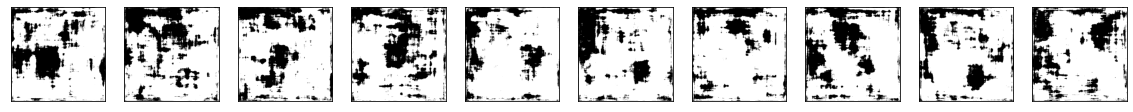

In [44]:
plot_images(generated_images)